In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import importlib

import seaborn as sns
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

state = 1
np.random.seed(1)


DATA_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/data/'
ROOT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/'
GROUND_PATH = DATA_PATH + '/groundTruth/'
ORI_IMAGE_PATH = DATA_PATH + '/images/'
OUT_IMAGE_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/image/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/model/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/result/'
LOG_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/logs/'


def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(OUT_IMAGE_PATH):
        os.makedirs(OUT_IMAGE_PATH)
    path = os.path.join(OUT_IMAGE_PATH, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
X_train = np.load(DATA_PATH + 'X_train_ori.npy')
X_test = np.load(DATA_PATH + 'X_test_ori.npy')
X_val = np.load(DATA_PATH + 'X_val_ori.npy')
y_train = np.load(DATA_PATH + 'y_train_concat.npy')
y_test = np.load(DATA_PATH + 'y_test_concat.npy')
y_val = np.load(DATA_PATH + 'y_val_concat.npy')
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((200, 320, 480, 3),
 (200, 320, 480, 3),
 (100, 320, 480, 3),
 (200, 320, 480, 1),
 (200, 320, 480, 1),
 (100, 320, 480, 1))

In [ ]:

import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, add, Activation, Input, \
                            Lambda, MaxPooling2D, concatenate
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.initializers import he_normal, glorot_normal
from keras import backend as K
import tensorflow as tf

from loss_functions.Loss_Functions import cross_entropy_balanced, pixel_error
from my_models.ResNet_UNet_Side_Fuse import u_res_side_fuse

In [6]:
model_unet_res_fuse = u_res_side_fuse(input_shape=(320, 480, 3))
model_unet_res_fuse.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
pre-process (Lambda)            (None, 320, 480, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 320, 480, 16) 1216        pre-process[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 320, 480, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
act1 (Acti

In [7]:
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=3e-5)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_RES_Fuse', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=3e-3, beta_1=0.9, beta_2=0.999)

model_unet_res_fuse.compile(loss={'o1': cross_entropy_balanced,
                        'o2': cross_entropy_balanced,
                        'o3': cross_entropy_balanced,
                        'o4': cross_entropy_balanced,
                        'o5': cross_entropy_balanced,
                        'ofuse': cross_entropy_balanced,
                        },
                  metrics={'ofuse': pixel_error},
                  optimizer=optimizer)

results = model_unet_res_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=300, callbacks=callback_list, verbose=2)

Train on 200 samples, validate on 100 samples


Epoch 1/300


Epoch 00001: val_loss improved from inf to 1.95274, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 54s - loss: 0.3773 - o1_loss: 0.0624 - o2_loss: 0.0627 - o3_loss: 0.0629 - o4_loss: 0.0608 - o5_loss: 0.0639 - ofuse_loss: 0.0645 - ofuse_pixel_error: 0.5385 - val_loss: 1.9527 - val_o1_loss: 0.0854 - val_o2_loss: 0.0962 - val_o3_loss: 0.2733 - val_o4_loss: 0.5053 - val_o5_loss: 0.5347 - val_ofuse_loss: 0.4578 - val_ofuse_pixel_error: 0.9184


Epoch 2/300


Epoch 00002: val_loss improved from 1.95274 to 0.89256, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 32s - loss: 0.3627 - o1_loss: 0.0581 - o2_loss: 0.0626 - o3_loss: 0.0617 - o4_loss: 0.0548 - o5_loss: 0.0600 - ofuse_loss: 0.0655 - ofuse_pixel_error: 0.5736 - val_loss: 0.8926 - val_o1_loss: 0.0686 - val_o2_loss: 0.0684 - val_o3_loss: 0.0897 - val_o4_loss: 0.2374 - val_o5_loss: 0.2393 - val_ofuse_loss: 0.1892 - val_ofuse_pixel_error: 0.8516


Epoch 3/300


Epoch 00003: val_loss improved from 0.89256 to 0.62316, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 32s - loss: 0.3433 - o1_loss: 0.0556 - o2_loss: 0.0596 - o3_loss: 0.0551 - o4_loss: 0.0538 - o5_loss: 0.0551 - ofuse_loss: 0.0641 - ofuse_pixel_error: 0.5067 - val_loss: 0.6232 - val_o1_loss: 0.1015 - val_o2_loss: 0.0745 - val_o3_loss: 0.0670 - val_o4_loss: 0.1197 - val_o5_loss: 0.1763 - val_ofuse_loss: 0.0841 - val_ofuse_pixel_error: 0.6771


Epoch 4/300


Epoch 00004: val_loss did not improve
 - 32s - loss: 0.3188 - o1_loss: 0.0545 - o2_loss: 0.0538 - o3_loss: 0.0515 - o4_loss: 0.0523 - o5_loss: 0.0510 - ofuse_loss: 0.0557 - ofuse_pixel_error: 0.3162 - val_loss: 2.2996 - val_o1_loss: 0.1240 - val_o2_loss: 0.2603 - val_o3_loss: 0.3022 - val_o4_loss: 0.4953 - val_o5_loss: 0.7267 - val_ofuse_loss: 0.3910 - val_ofuse_pixel_error: 0.6555


Epoch 5/300


Epoch 00005: val_loss did not improve
 - 33s - loss: 0.3070 - o1_loss: 0.0538 - o2_loss: 0.0518 - o3_loss: 0.0502 - o4_loss: 0.0502 - o5_loss: 0.0500 - ofuse_loss: 0.0509 - ofuse_pixel_error: 0.3222 - val_loss: 2.0689 - val_o1_loss: 0.0846 - val_o2_loss: 0.1154 - val_o3_loss: 0.1628 - val_o4_loss: 0.6086 - val_o5_loss: 0.6215 - val_ofuse_loss: 0.4760 - val_ofuse_pixel_error: 0.1230


Epoch 6/300


Epoch 00006: val_loss did not improve
 - 32s - loss: 0.3035 - o1_loss: 0.0539 - o2_loss: 0.0514 - o3_loss: 0.0499 - o4_loss: 0.0494 - o5_loss: 0.0495 - ofuse_loss: 0.0495 - ofuse_pixel_error: 0.3061 - val_loss: 2.4055 - val_o1_loss: 0.0856 - val_o2_loss: 0.2695 - val_o3_loss: 0.6330 - val_o4_loss: 0.5172 - val_o5_loss: 0.4515 - val_ofuse_loss: 0.4486 - val_ofuse_pixel_error: 0.1304


Epoch 7/300


Epoch 00007: val_loss improved from 0.62316 to 0.48174, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 32s - loss: 0.2942 - o1_loss: 0.0523 - o2_loss: 0.0501 - o3_loss: 0.0484 - o4_loss: 0.0478 - o5_loss: 0.0479 - ofuse_loss: 0.0477 - ofuse_pixel_error: 0.2904 - val_loss: 0.4817 - val_o1_loss: 0.0744 - val_o2_loss: 0.0945 - val_o3_loss: 0.0754 - val_o4_loss: 0.0792 - val_o5_loss: 0.0825 - val_ofuse_loss: 0.0757 - val_ofuse_pixel_error: 0.3585


Epoch 8/300


Epoch 00008: val_loss improved from 0.48174 to 0.45989, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 32s - loss: 0.2900 - o1_loss: 0.0521 - o2_loss: 0.0495 - o3_loss: 0.0476 - o4_loss: 0.0470 - o5_loss: 0.0469 - ofuse_loss: 0.0470 - ofuse_pixel_error: 0.2804 - val_loss: 0.4599 - val_o1_loss: 0.0794 - val_o2_loss: 0.0809 - val_o3_loss: 0.0723 - val_o4_loss: 0.0730 - val_o5_loss: 0.0806 - val_ofuse_loss: 0.0737 - val_ofuse_pixel_error: 0.7581


Epoch 9/300


Epoch 00009: val_loss improved from 0.45989 to 0.39887, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 33s - loss: 0.2840 - o1_loss: 0.0510 - o2_loss: 0.0483 - o3_loss: 0.0466 - o4_loss: 0.0461 - o5_loss: 0.0461 - ofuse_loss: 0.0460 - ofuse_pixel_error: 0.2826 - val_loss: 0.3989 - val_o1_loss: 0.0656 - val_o2_loss: 0.0647 - val_o3_loss: 0.0635 - val_o4_loss: 0.0670 - val_o5_loss: 0.0725 - val_ofuse_loss: 0.0656 - val_ofuse_pixel_error: 0.5583


Epoch 10/300


Epoch 00010: val_loss improved from 0.39887 to 0.35893, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 33s - loss: 0.2788 - o1_loss: 0.0503 - o2_loss: 0.0475 - o3_loss: 0.0456 - o4_loss: 0.0451 - o5_loss: 0.0452 - ofuse_loss: 0.0451 - ofuse_pixel_error: 0.2752 - val_loss: 0.3589 - val_o1_loss: 0.0607 - val_o2_loss: 0.0591 - val_o3_loss: 0.0585 - val_o4_loss: 0.0601 - val_o5_loss: 0.0618 - val_ofuse_loss: 0.0588 - val_ofuse_pixel_error: 0.4486


Epoch 11/300


Epoch 00011: val_loss did not improve
 - 32s - loss: 0.2783 - o1_loss: 0.0503 - o2_loss: 0.0473 - o3_loss: 0.0455 - o4_loss: 0.0451 - o5_loss: 0.0452 - ofuse_loss: 0.0450 - ofuse_pixel_error: 0.2836 - val_loss: 0.3605 - val_o1_loss: 0.0633 - val_o2_loss: 0.0605 - val_o3_loss: 0.0591 - val_o4_loss: 0.0582 - val_o5_loss: 0.0602 - val_ofuse_loss: 0.0590 - val_ofuse_pixel_error: 0.5570


Epoch 12/300


Epoch 00012: val_loss did not improve
 - 33s - loss: 0.2776 - o1_loss: 0.0504 - o2_loss: 0.0474 - o3_loss: 0.0454 - o4_loss: 0.0448 - o5_loss: 0.0448 - ofuse_loss: 0.0448 - ofuse_pixel_error: 0.2806 - val_loss: 0.3654 - val_o1_loss: 0.0597 - val_o2_loss: 0.0592 - val_o3_loss: 0.0597 - val_o4_loss: 0.0611 - val_o5_loss: 0.0652 - val_ofuse_loss: 0.0605 - val_ofuse_pixel_error: 0.4385


Epoch 13/300


Epoch 00013: val_loss improved from 0.35893 to 0.35726, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 33s - loss: 0.2720 - o1_loss: 0.0492 - o2_loss: 0.0462 - o3_loss: 0.0445 - o4_loss: 0.0440 - o5_loss: 0.0440 - ofuse_loss: 0.0440 - ofuse_pixel_error: 0.2623 - val_loss: 0.3573 - val_o1_loss: 0.0619 - val_o2_loss: 0.0601 - val_o3_loss: 0.0591 - val_o4_loss: 0.0585 - val_o5_loss: 0.0590 - val_ofuse_loss: 0.0587 - val_ofuse_pixel_error: 0.3475


Epoch 14/300


Epoch 00014: val_loss improved from 0.35726 to 0.33496, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 33s - loss: 0.2671 - o1_loss: 0.0488 - o2_loss: 0.0455 - o3_loss: 0.0435 - o4_loss: 0.0431 - o5_loss: 0.0431 - ofuse_loss: 0.0431 - ofuse_pixel_error: 0.2729 - val_loss: 0.3350 - val_o1_loss: 0.0590 - val_o2_loss: 0.0565 - val_o3_loss: 0.0552 - val_o4_loss: 0.0550 - val_o5_loss: 0.0545 - val_ofuse_loss: 0.0547 - val_ofuse_pixel_error: 0.3609


Epoch 15/300


Epoch 00015: val_loss did not improve
 - 34s - loss: 0.2687 - o1_loss: 0.0490 - o2_loss: 0.0459 - o3_loss: 0.0438 - o4_loss: 0.0433 - o5_loss: 0.0433 - ofuse_loss: 0.0433 - ofuse_pixel_error: 0.2662 - val_loss: 0.3432 - val_o1_loss: 0.0599 - val_o2_loss: 0.0576 - val_o3_loss: 0.0559 - val_o4_loss: 0.0564 - val_o5_loss: 0.0569 - val_ofuse_loss: 0.0564 - val_ofuse_pixel_error: 0.3491


Epoch 16/300


Epoch 00016: val_loss did not improve
 - 32s - loss: 0.2678 - o1_loss: 0.0487 - o2_loss: 0.0456 - o3_loss: 0.0437 - o4_loss: 0.0433 - o5_loss: 0.0433 - ofuse_loss: 0.0432 - ofuse_pixel_error: 0.2643 - val_loss: 0.3378 - val_o1_loss: 0.0593 - val_o2_loss: 0.0560 - val_o3_loss: 0.0549 - val_o4_loss: 0.0557 - val_o5_loss: 0.0563 - val_ofuse_loss: 0.0557 - val_ofuse_pixel_error: 0.3547


Epoch 17/300


Epoch 00017: val_loss did not improve
 - 32s - loss: 0.2623 - o1_loss: 0.0481 - o2_loss: 0.0448 - o3_loss: 0.0427 - o4_loss: 0.0422 - o5_loss: 0.0423 - ofuse_loss: 0.0422 - ofuse_pixel_error: 0.2656 - val_loss: 0.3606 - val_o1_loss: 0.0613 - val_o2_loss: 0.0601 - val_o3_loss: 0.0583 - val_o4_loss: 0.0595 - val_o5_loss: 0.0622 - val_ofuse_loss: 0.0593 - val_ofuse_pixel_error: 0.4904


Epoch 18/300


Epoch 00018: val_loss improved from 0.33496 to 0.32980, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5


 - 33s - loss: 0.2591 - o1_loss: 0.0475 - o2_loss: 0.0442 - o3_loss: 0.0422 - o4_loss: 0.0417 - o5_loss: 0.0418 - ofuse_loss: 0.0417 - ofuse_pixel_error: 0.2600 - val_loss: 0.3298 - val_o1_loss: 0.0592 - val_o2_loss: 0.0555 - val_o3_loss: 0.0536 - val_o4_loss: 0.0536 - val_o5_loss: 0.0541 - val_ofuse_loss: 0.0538 - val_ofuse_pixel_error: 0.3444


Epoch 19/300


Epoch 00019: val_loss did not improve
 - 32s - loss: 0.2592 - o1_loss: 0.0475 - o2_loss: 0.0442 - o3_loss: 0.0423 - o4_loss: 0.0418 - o5_loss: 0.0418 - ofuse_loss: 0.0417 - ofuse_pixel_error: 0.2657 - val_loss: 0.3569 - val_o1_loss: 0.0627 - val_o2_loss: 0.0608 - val_o3_loss: 0.0580 - val_o4_loss: 0.0580 - val_o5_loss: 0.0587 - val_ofuse_loss: 0.0586 - val_ofuse_pixel_error: 0.2771


Epoch 20/300


Epoch 00020: val_loss did not improve
 - 32s - loss: 0.2538 - o1_loss: 0.0468 - o2_loss: 0.0434 - o3_loss: 0.0413 - o4_loss: 0.0408 - o5_loss: 0.0408 - ofuse_loss: 0.0408 - ofuse_pixel_error: 0.2567 - val_loss: 0.3857 - val_o1_loss: 0.0664 - val_o2_loss: 0.0671 - val_o3_loss: 0.0640 - val_o4_loss: 0.0624 - val_o5_loss: 0.0628 - val_ofuse_loss: 0.0631 - val_ofuse_pixel_error: 0.1563


Epoch 21/300


Epoch 00021: val_loss did not improve
 - 32s - loss: 0.2498 - o1_loss: 0.0463 - o2_loss: 0.0427 - o3_loss: 0.0406 - o4_loss: 0.0401 - o5_loss: 0.0401 - ofuse_loss: 0.0400 - ofuse_pixel_error: 0.2524 - val_loss: 0.3428 - val_o1_loss: 0.0596 - val_o2_loss: 0.0589 - val_o3_loss: 0.0559 - val_o4_loss: 0.0558 - val_o5_loss: 0.0569 - val_ofuse_loss: 0.0556 - val_ofuse_pixel_error: 0.3821


Epoch 22/300


Epoch 00022: val_loss did not improve
 - 32s - loss: 0.2495 - o1_loss: 0.0461 - o2_loss: 0.0427 - o3_loss: 0.0405 - o4_loss: 0.0401 - o5_loss: 0.0401 - ofuse_loss: 0.0400 - ofuse_pixel_error: 0.2562 - val_loss: 0.3321 - val_o1_loss: 0.0589 - val_o2_loss: 0.0562 - val_o3_loss: 0.0549 - val_o4_loss: 0.0540 - val_o5_loss: 0.0542 - val_ofuse_loss: 0.0540 - val_ofuse_pixel_error: 0.2836


Epoch 23/300


Epoch 00023: val_loss did not improve
 - 32s - loss: 0.2424 - o1_loss: 0.0450 - o2_loss: 0.0415 - o3_loss: 0.0394 - o4_loss: 0.0388 - o5_loss: 0.0389 - ofuse_loss: 0.0388 - ofuse_pixel_error: 0.2485 - val_loss: 0.3559 - val_o1_loss: 0.0630 - val_o2_loss: 0.0605 - val_o3_loss: 0.0581 - val_o4_loss: 0.0579 - val_o5_loss: 0.0582 - val_ofuse_loss: 0.0582 - val_ofuse_pixel_error: 0.2324


Epoch 24/300


Epoch 00024: val_loss did not improve
 - 32s - loss: 0.2466 - o1_loss: 0.0456 - o2_loss: 0.0422 - o3_loss: 0.0401 - o4_loss: 0.0396 - o5_loss: 0.0396 - ofuse_loss: 0.0395 - ofuse_pixel_error: 0.2508 - val_loss: 0.3902 - val_o1_loss: 0.0652 - val_o2_loss: 0.0652 - val_o3_loss: 0.0639 - val_o4_loss: 0.0641 - val_o5_loss: 0.0672 - val_ofuse_loss: 0.0645 - val_ofuse_pixel_error: 0.4364


Epoch 25/300


Epoch 00025: val_loss did not improve
 - 32s - loss: 0.2403 - o1_loss: 0.0447 - o2_loss: 0.0411 - o3_loss: 0.0390 - o4_loss: 0.0385 - o5_loss: 0.0385 - ofuse_loss: 0.0384 - ofuse_pixel_error: 0.2476 - val_loss: 0.3883 - val_o1_loss: 0.0677 - val_o2_loss: 0.0652 - val_o3_loss: 0.0638 - val_o4_loss: 0.0632 - val_o5_loss: 0.0642 - val_ofuse_loss: 0.0642 - val_ofuse_pixel_error: 0.2387


Epoch 26/300


Epoch 00026: val_loss did not improve
 - 32s - loss: 0.2320 - o1_loss: 0.0435 - o2_loss: 0.0398 - o3_loss: 0.0375 - o4_loss: 0.0371 - o5_loss: 0.0371 - ofuse_loss: 0.0370 - ofuse_pixel_error: 0.2421 - val_loss: 0.4717 - val_o1_loss: 0.0806 - val_o2_loss: 0.0796 - val_o3_loss: 0.0773 - val_o4_loss: 0.0773 - val_o5_loss: 0.0786 - val_ofuse_loss: 0.0783 - val_ofuse_pixel_error: 0.1565


Epoch 27/300


Epoch 00027: val_loss did not improve
 - 32s - loss: 0.2311 - o1_loss: 0.0435 - o2_loss: 0.0396 - o3_loss: 0.0374 - o4_loss: 0.0369 - o5_loss: 0.0369 - ofuse_loss: 0.0368 - ofuse_pixel_error: 0.2413 - val_loss: 0.4117 - val_o1_loss: 0.0703 - val_o2_loss: 0.0707 - val_o3_loss: 0.0690 - val_o4_loss: 0.0665 - val_o5_loss: 0.0675 - val_ofuse_loss: 0.0677 - val_ofuse_pixel_error: 0.1626


Epoch 28/300


Epoch 00028: val_loss did not improve
 - 32s - loss: 0.2238 - o1_loss: 0.0423 - o2_loss: 0.0383 - o3_loss: 0.0362 - o4_loss: 0.0357 - o5_loss: 0.0357 - ofuse_loss: 0.0356 - ofuse_pixel_error: 0.2396 - val_loss: 0.3819 - val_o1_loss: 0.0658 - val_o2_loss: 0.0630 - val_o3_loss: 0.0619 - val_o4_loss: 0.0626 - val_o5_loss: 0.0653 - val_ofuse_loss: 0.0632 - val_ofuse_pixel_error: 0.2994


Epoch 29/300


Epoch 00029: val_loss did not improve
 - 32s - loss: 0.2203 - o1_loss: 0.0418 - o2_loss: 0.0377 - o3_loss: 0.0356 - o4_loss: 0.0351 - o5_loss: 0.0351 - ofuse_loss: 0.0350 - ofuse_pixel_error: 0.2347 - val_loss: 0.4339 - val_o1_loss: 0.0751 - val_o2_loss: 0.0738 - val_o3_loss: 0.0725 - val_o4_loss: 0.0700 - val_o5_loss: 0.0712 - val_ofuse_loss: 0.0714 - val_ofuse_pixel_error: 0.1504


Epoch 30/300


Epoch 00030: val_loss did not improve
 - 32s - loss: 0.2186 - o1_loss: 0.0416 - o2_loss: 0.0375 - o3_loss: 0.0353 - o4_loss: 0.0348 - o5_loss: 0.0348 - ofuse_loss: 0.0347 - ofuse_pixel_error: 0.2359 - val_loss: 0.4345 - val_o1_loss: 0.0774 - val_o2_loss: 0.0725 - val_o3_loss: 0.0726 - val_o4_loss: 0.0701 - val_o5_loss: 0.0704 - val_ofuse_loss: 0.0715 - val_ofuse_pixel_error: 0.1579


Epoch 31/300


Epoch 00031: val_loss did not improve
 - 32s - loss: 0.2128 - o1_loss: 0.0406 - o2_loss: 0.0365 - o3_loss: 0.0343 - o4_loss: 0.0338 - o5_loss: 0.0339 - ofuse_loss: 0.0337 - ofuse_pixel_error: 0.2336 - val_loss: 0.4248 - val_o1_loss: 0.0723 - val_o2_loss: 0.0711 - val_o3_loss: 0.0702 - val_o4_loss: 0.0695 - val_o5_loss: 0.0710 - val_ofuse_loss: 0.0707 - val_ofuse_pixel_error: 0.2600


Epoch 32/300


Epoch 00032: val_loss did not improve
 - 33s - loss: 0.2101 - o1_loss: 0.0402 - o2_loss: 0.0360 - o3_loss: 0.0338 - o4_loss: 0.0334 - o5_loss: 0.0334 - ofuse_loss: 0.0333 - ofuse_pixel_error: 0.2299 - val_loss: 0.4669 - val_o1_loss: 0.0776 - val_o2_loss: 0.0777 - val_o3_loss: 0.0780 - val_o4_loss: 0.0766 - val_o5_loss: 0.0785 - val_ofuse_loss: 0.0785 - val_ofuse_pixel_error: 0.1479


Epoch 33/300


Epoch 00033: val_loss did not improve
 - 32s - loss: 0.2053 - o1_loss: 0.0395 - o2_loss: 0.0352 - o3_loss: 0.0330 - o4_loss: 0.0325 - o5_loss: 0.0326 - ofuse_loss: 0.0325 - ofuse_pixel_error: 0.2230 - val_loss: 0.5412 - val_o1_loss: 0.0952 - val_o2_loss: 0.0915 - val_o3_loss: 0.0883 - val_o4_loss: 0.0869 - val_o5_loss: 0.0898 - val_ofuse_loss: 0.0896 - val_ofuse_pixel_error: 0.1242


Epoch 34/300


Epoch 00034: val_loss did not improve
 - 33s - loss: 0.2052 - o1_loss: 0.0394 - o2_loss: 0.0352 - o3_loss: 0.0330 - o4_loss: 0.0325 - o5_loss: 0.0326 - ofuse_loss: 0.0325 - ofuse_pixel_error: 0.2320 - val_loss: 0.6376 - val_o1_loss: 0.0914 - val_o2_loss: 0.0975 - val_o3_loss: 0.1066 - val_o4_loss: 0.1124 - val_o5_loss: 0.1183 - val_ofuse_loss: 0.1115 - val_ofuse_pixel_error: 0.1152


Epoch 35/300


Epoch 00035: val_loss did not improve
 - 32s - loss: 0.2045 - o1_loss: 0.0396 - o2_loss: 0.0351 - o3_loss: 0.0328 - o4_loss: 0.0324 - o5_loss: 0.0324 - ofuse_loss: 0.0323 - ofuse_pixel_error: 0.2210 - val_loss: 0.5034 - val_o1_loss: 0.0870 - val_o2_loss: 0.0832 - val_o3_loss: 0.0835 - val_o4_loss: 0.0822 - val_o5_loss: 0.0830 - val_ofuse_loss: 0.0845 - val_ofuse_pixel_error: 0.1600


Epoch 36/300


Epoch 00036: val_loss did not improve
 - 32s - loss: 0.1986 - o1_loss: 0.0384 - o2_loss: 0.0341 - o3_loss: 0.0319 - o4_loss: 0.0314 - o5_loss: 0.0314 - ofuse_loss: 0.0314 - ofuse_pixel_error: 0.2203 - val_loss: 0.4483 - val_o1_loss: 0.0749 - val_o2_loss: 0.0749 - val_o3_loss: 0.0734 - val_o4_loss: 0.0744 - val_o5_loss: 0.0755 - val_ofuse_loss: 0.0753 - val_ofuse_pixel_error: 0.1860


Epoch 37/300


Epoch 00037: val_loss did not improve
 - 33s - loss: 0.1942 - o1_loss: 0.0379 - o2_loss: 0.0334 - o3_loss: 0.0311 - o4_loss: 0.0306 - o5_loss: 0.0307 - ofuse_loss: 0.0305 - ofuse_pixel_error: 0.2202 - val_loss: 0.4353 - val_o1_loss: 0.0800 - val_o2_loss: 0.0728 - val_o3_loss: 0.0699 - val_o4_loss: 0.0699 - val_o5_loss: 0.0710 - val_ofuse_loss: 0.0716 - val_ofuse_pixel_error: 0.2417


Epoch 38/300


Epoch 00038: val_loss did not improve
 - 33s - loss: 0.1864 - o1_loss: 0.0366 - o2_loss: 0.0321 - o3_loss: 0.0298 - o4_loss: 0.0293 - o5_loss: 0.0293 - ofuse_loss: 0.0292 - ofuse_pixel_error: 0.2172 - val_loss: 0.4524 - val_o1_loss: 0.0819 - val_o2_loss: 0.0765 - val_o3_loss: 0.0731 - val_o4_loss: 0.0725 - val_o5_loss: 0.0739 - val_ofuse_loss: 0.0744 - val_ofuse_pixel_error: 0.2434


Epoch 39/300


Epoch 00039: val_loss did not improve
 - 32s - loss: 0.1875 - o1_loss: 0.0369 - o2_loss: 0.0322 - o3_loss: 0.0300 - o4_loss: 0.0295 - o5_loss: 0.0295 - ofuse_loss: 0.0294 - ofuse_pixel_error: 0.2139 - val_loss: 0.5164 - val_o1_loss: 0.0893 - val_o2_loss: 0.0854 - val_o3_loss: 0.0838 - val_o4_loss: 0.0846 - val_o5_loss: 0.0867 - val_ofuse_loss: 0.0866 - val_ofuse_pixel_error: 0.1815


Epoch 40/300


Epoch 00040: val_loss did not improve
 - 33s - loss: 0.1843 - o1_loss: 0.0363 - o2_loss: 0.0317 - o3_loss: 0.0295 - o4_loss: 0.0289 - o5_loss: 0.0290 - ofuse_loss: 0.0289 - ofuse_pixel_error: 0.2129 - val_loss: 0.4922 - val_o1_loss: 0.0859 - val_o2_loss: 0.0821 - val_o3_loss: 0.0799 - val_o4_loss: 0.0798 - val_o5_loss: 0.0822 - val_ofuse_loss: 0.0823 - val_ofuse_pixel_error: 0.1746


Epoch 41/300


Epoch 00041: val_loss did not improve
 - 32s - loss: 0.1826 - o1_loss: 0.0361 - o2_loss: 0.0313 - o3_loss: 0.0291 - o4_loss: 0.0287 - o5_loss: 0.0287 - ofuse_loss: 0.0286 - ofuse_pixel_error: 0.2114 - val_loss: 0.4917 - val_o1_loss: 0.0852 - val_o2_loss: 0.0798 - val_o3_loss: 0.0792 - val_o4_loss: 0.0812 - val_o5_loss: 0.0835 - val_ofuse_loss: 0.0828 - val_ofuse_pixel_error: 0.2097


Epoch 42/300


Epoch 00042: val_loss did not improve
 - 32s - loss: 0.1810 - o1_loss: 0.0359 - o2_loss: 0.0311 - o3_loss: 0.0288 - o4_loss: 0.0284 - o5_loss: 0.0285 - ofuse_loss: 0.0283 - ofuse_pixel_error: 0.2110 - val_loss: 0.4506 - val_o1_loss: 0.0796 - val_o2_loss: 0.0751 - val_o3_loss: 0.0732 - val_o4_loss: 0.0728 - val_o5_loss: 0.0750 - val_ofuse_loss: 0.0749 - val_ofuse_pixel_error: 0.2051


Epoch 43/300


Epoch 00043: val_loss did not improve
 - 32s - loss: 0.1766 - o1_loss: 0.0353 - o2_loss: 0.0304 - o3_loss: 0.0281 - o4_loss: 0.0276 - o5_loss: 0.0277 - ofuse_loss: 0.0275 - ofuse_pixel_error: 0.2087 - val_loss: 0.4896 - val_o1_loss: 0.0879 - val_o2_loss: 0.0827 - val_o3_loss: 0.0793 - val_o4_loss: 0.0780 - val_o5_loss: 0.0805 - val_ofuse_loss: 0.0810 - val_ofuse_pixel_error: 0.1946


Epoch 44/300


Epoch 00044: val_loss did not improve
 - 32s - loss: 0.1763 - o1_loss: 0.0353 - o2_loss: 0.0303 - o3_loss: 0.0280 - o4_loss: 0.0276 - o5_loss: 0.0276 - ofuse_loss: 0.0275 - ofuse_pixel_error: 0.2072 - val_loss: 0.4936 - val_o1_loss: 0.0877 - val_o2_loss: 0.0828 - val_o3_loss: 0.0807 - val_o4_loss: 0.0794 - val_o5_loss: 0.0813 - val_ofuse_loss: 0.0818 - val_ofuse_pixel_error: 0.1938


Epoch 45/300


Epoch 00045: val_loss did not improve
 - 32s - loss: 0.1749 - o1_loss: 0.0350 - o2_loss: 0.0300 - o3_loss: 0.0278 - o4_loss: 0.0273 - o5_loss: 0.0274 - ofuse_loss: 0.0273 - ofuse_pixel_error: 0.2061 - val_loss: 0.5541 - val_o1_loss: 0.0935 - val_o2_loss: 0.0954 - val_o3_loss: 0.0907 - val_o4_loss: 0.0901 - val_o5_loss: 0.0916 - val_ofuse_loss: 0.0927 - val_ofuse_pixel_error: 0.1800


Epoch 46/300


Epoch 00046: val_loss did not improve
 - 32s - loss: 0.1735 - o1_loss: 0.0350 - o2_loss: 0.0298 - o3_loss: 0.0276 - o4_loss: 0.0271 - o5_loss: 0.0270 - ofuse_loss: 0.0270 - ofuse_pixel_error: 0.2009 - val_loss: 0.7114 - val_o1_loss: 0.1160 - val_o2_loss: 0.1207 - val_o3_loss: 0.1172 - val_o4_loss: 0.1174 - val_o5_loss: 0.1195 - val_ofuse_loss: 0.1206 - val_ofuse_pixel_error: 0.0906


Epoch 47/300


Epoch 00047: val_loss did not improve
 - 32s - loss: 0.1726 - o1_loss: 0.0348 - o2_loss: 0.0296 - o3_loss: 0.0274 - o4_loss: 0.0269 - o5_loss: 0.0269 - ofuse_loss: 0.0269 - ofuse_pixel_error: 0.2043 - val_loss: 0.6412 - val_o1_loss: 0.1149 - val_o2_loss: 0.1082 - val_o3_loss: 0.1019 - val_o4_loss: 0.1031 - val_o5_loss: 0.1063 - val_ofuse_loss: 0.1068 - val_ofuse_pixel_error: 0.1441


Epoch 48/300


Epoch 00048: val_loss did not improve
 - 32s - loss: 0.1660 - o1_loss: 0.0341 - o2_loss: 0.0286 - o3_loss: 0.0262 - o4_loss: 0.0257 - o5_loss: 0.0258 - ofuse_loss: 0.0257 - ofuse_pixel_error: 0.1964 - val_loss: 0.5547 - val_o1_loss: 0.1088 - val_o2_loss: 0.0977 - val_o3_loss: 0.0891 - val_o4_loss: 0.0842 - val_o5_loss: 0.0851 - val_ofuse_loss: 0.0897 - val_ofuse_pixel_error: 0.1623


Epoch 49/300


Epoch 00049: val_loss did not improve
 - 32s - loss: 0.1631 - o1_loss: 0.0335 - o2_loss: 0.0281 - o3_loss: 0.0258 - o4_loss: 0.0253 - o5_loss: 0.0253 - ofuse_loss: 0.0252 - ofuse_pixel_error: 0.1980 - val_loss: 0.5851 - val_o1_loss: 0.1062 - val_o2_loss: 0.1039 - val_o3_loss: 0.0945 - val_o4_loss: 0.0916 - val_o5_loss: 0.0934 - val_ofuse_loss: 0.0955 - val_ofuse_pixel_error: 0.1313


Epoch 50/300


Epoch 00050: val_loss did not improve
 - 32s - loss: 0.1633 - o1_loss: 0.0336 - o2_loss: 0.0281 - o3_loss: 0.0257 - o4_loss: 0.0253 - o5_loss: 0.0253 - ofuse_loss: 0.0252 - ofuse_pixel_error: 0.1937 - val_loss: 0.5088 - val_o1_loss: 0.0908 - val_o2_loss: 0.0894 - val_o3_loss: 0.0838 - val_o4_loss: 0.0802 - val_o5_loss: 0.0813 - val_ofuse_loss: 0.0834 - val_ofuse_pixel_error: 0.2110


Epoch 51/300


Epoch 00051: val_loss did not improve
 - 32s - loss: 0.1588 - o1_loss: 0.0331 - o2_loss: 0.0273 - o3_loss: 0.0249 - o4_loss: 0.0245 - o5_loss: 0.0245 - ofuse_loss: 0.0244 - ofuse_pixel_error: 0.1889 - val_loss: 0.5445 - val_o1_loss: 0.0981 - val_o2_loss: 0.0949 - val_o3_loss: 0.0882 - val_o4_loss: 0.0861 - val_o5_loss: 0.0874 - val_ofuse_loss: 0.0899 - val_ofuse_pixel_error: 0.1710


Epoch 52/300


Epoch 00052: val_loss did not improve
 - 32s - loss: 0.1585 - o1_loss: 0.0329 - o2_loss: 0.0273 - o3_loss: 0.0250 - o4_loss: 0.0244 - o5_loss: 0.0244 - ofuse_loss: 0.0244 - ofuse_pixel_error: 0.1907 - val_loss: 0.6103 - val_o1_loss: 0.1048 - val_o2_loss: 0.1070 - val_o3_loss: 0.1001 - val_o4_loss: 0.0973 - val_o5_loss: 0.1006 - val_ofuse_loss: 0.1006 - val_ofuse_pixel_error: 0.1277


Epoch 53/300


Epoch 00053: val_loss did not improve
 - 32s - loss: 0.1650 - o1_loss: 0.0343 - o2_loss: 0.0285 - o3_loss: 0.0259 - o4_loss: 0.0254 - o5_loss: 0.0255 - ofuse_loss: 0.0254 - ofuse_pixel_error: 0.1915 - val_loss: 0.5518 - val_o1_loss: 0.0973 - val_o2_loss: 0.0938 - val_o3_loss: 0.0903 - val_o4_loss: 0.0888 - val_o5_loss: 0.0903 - val_ofuse_loss: 0.0913 - val_ofuse_pixel_error: 0.1502


Epoch 54/300


Epoch 00054: val_loss did not improve
 - 32s - loss: 0.1606 - o1_loss: 0.0336 - o2_loss: 0.0277 - o3_loss: 0.0252 - o4_loss: 0.0247 - o5_loss: 0.0247 - ofuse_loss: 0.0246 - ofuse_pixel_error: 0.1940 - val_loss: 0.5501 - val_o1_loss: 0.0945 - val_o2_loss: 0.0968 - val_o3_loss: 0.0900 - val_o4_loss: 0.0882 - val_o5_loss: 0.0895 - val_ofuse_loss: 0.0911 - val_ofuse_pixel_error: 0.1652


Epoch 55/300


Epoch 00055: val_loss did not improve
 - 32s - loss: 0.1593 - o1_loss: 0.0335 - o2_loss: 0.0275 - o3_loss: 0.0249 - o4_loss: 0.0244 - o5_loss: 0.0245 - ofuse_loss: 0.0244 - ofuse_pixel_error: 0.1875 - val_loss: 0.6666 - val_o1_loss: 0.1074 - val_o2_loss: 0.1119 - val_o3_loss: 0.1090 - val_o4_loss: 0.1109 - val_o5_loss: 0.1140 - val_ofuse_loss: 0.1136 - val_ofuse_pixel_error: 0.1209


Epoch 56/300


Epoch 00056: val_loss did not improve
 - 32s - loss: 0.1556 - o1_loss: 0.0331 - o2_loss: 0.0269 - o3_loss: 0.0242 - o4_loss: 0.0238 - o5_loss: 0.0238 - ofuse_loss: 0.0237 - ofuse_pixel_error: 0.1852 - val_loss: 0.6023 - val_o1_loss: 0.0979 - val_o2_loss: 0.1047 - val_o3_loss: 0.1003 - val_o4_loss: 0.0981 - val_o5_loss: 0.0999 - val_ofuse_loss: 0.1012 - val_ofuse_pixel_error: 0.1602


Epoch 57/300


Epoch 00057: val_loss did not improve
 - 33s - loss: 0.1501 - o1_loss: 0.0322 - o2_loss: 0.0259 - o3_loss: 0.0233 - o4_loss: 0.0229 - o5_loss: 0.0229 - ofuse_loss: 0.0228 - ofuse_pixel_error: 0.1812 - val_loss: 0.5609 - val_o1_loss: 0.0959 - val_o2_loss: 0.1012 - val_o3_loss: 0.0929 - val_o4_loss: 0.0886 - val_o5_loss: 0.0900 - val_ofuse_loss: 0.0923 - val_ofuse_pixel_error: 0.1690


Epoch 58/300


Epoch 00058: val_loss did not improve
 - 32s - loss: 0.1506 - o1_loss: 0.0325 - o2_loss: 0.0260 - o3_loss: 0.0234 - o4_loss: 0.0229 - o5_loss: 0.0230 - ofuse_loss: 0.0229 - ofuse_pixel_error: 0.1798 - val_loss: 0.5807 - val_o1_loss: 0.1013 - val_o2_loss: 0.1009 - val_o3_loss: 0.0948 - val_o4_loss: 0.0923 - val_o5_loss: 0.0959 - val_ofuse_loss: 0.0954 - val_ofuse_pixel_error: 0.2045


Epoch 59/300


Epoch 00059: val_loss did not improve
 - 32s - loss: 0.1498 - o1_loss: 0.0323 - o2_loss: 0.0259 - o3_loss: 0.0232 - o4_loss: 0.0228 - o5_loss: 0.0228 - ofuse_loss: 0.0227 - ofuse_pixel_error: 0.1778 - val_loss: 0.5986 - val_o1_loss: 0.0965 - val_o2_loss: 0.1029 - val_o3_loss: 0.0998 - val_o4_loss: 0.0976 - val_o5_loss: 0.1005 - val_ofuse_loss: 0.1013 - val_ofuse_pixel_error: 0.1978


Epoch 60/300


Epoch 00060: val_loss did not improve
 - 32s - loss: 0.1479 - o1_loss: 0.0321 - o2_loss: 0.0255 - o3_loss: 0.0229 - o4_loss: 0.0225 - o5_loss: 0.0225 - ofuse_loss: 0.0224 - ofuse_pixel_error: 0.1775 - val_loss: 0.7158 - val_o1_loss: 0.1151 - val_o2_loss: 0.1234 - val_o3_loss: 0.1196 - val_o4_loss: 0.1160 - val_o5_loss: 0.1203 - val_ofuse_loss: 0.1214 - val_ofuse_pixel_error: 0.1266


Epoch 61/300


Epoch 00061: val_loss did not improve
 - 32s - loss: 0.1468 - o1_loss: 0.0322 - o2_loss: 0.0254 - o3_loss: 0.0226 - o4_loss: 0.0222 - o5_loss: 0.0222 - ofuse_loss: 0.0221 - ofuse_pixel_error: 0.1757 - val_loss: 0.8678 - val_o1_loss: 0.1359 - val_o2_loss: 0.1525 - val_o3_loss: 0.1454 - val_o4_loss: 0.1410 - val_o5_loss: 0.1453 - val_ofuse_loss: 0.1478 - val_ofuse_pixel_error: 0.1027


Epoch 62/300


Epoch 00062: val_loss did not improve
 - 32s - loss: 0.1448 - o1_loss: 0.0320 - o2_loss: 0.0251 - o3_loss: 0.0223 - o4_loss: 0.0218 - o5_loss: 0.0219 - ofuse_loss: 0.0218 - ofuse_pixel_error: 0.1730 - val_loss: 0.6232 - val_o1_loss: 0.1023 - val_o2_loss: 0.1106 - val_o3_loss: 0.1041 - val_o4_loss: 0.1000 - val_o5_loss: 0.1021 - val_ofuse_loss: 0.1042 - val_ofuse_pixel_error: 0.1798


Epoch 63/300


Epoch 00063: val_loss did not improve
 - 32s - loss: 0.1437 - o1_loss: 0.0319 - o2_loss: 0.0250 - o3_loss: 0.0221 - o4_loss: 0.0216 - o5_loss: 0.0216 - ofuse_loss: 0.0216 - ofuse_pixel_error: 0.1723 - val_loss: 0.6133 - val_o1_loss: 0.0993 - val_o2_loss: 0.1088 - val_o3_loss: 0.1029 - val_o4_loss: 0.0989 - val_o5_loss: 0.1005 - val_ofuse_loss: 0.1030 - val_ofuse_pixel_error: 0.1711


Epoch 64/300


Epoch 00064: val_loss did not improve
 - 32s - loss: 0.1430 - o1_loss: 0.0317 - o2_loss: 0.0249 - o3_loss: 0.0220 - o4_loss: 0.0215 - o5_loss: 0.0215 - ofuse_loss: 0.0215 - ofuse_pixel_error: 0.1717 - val_loss: 0.6078 - val_o1_loss: 0.1016 - val_o2_loss: 0.1066 - val_o3_loss: 0.0999 - val_o4_loss: 0.0981 - val_o5_loss: 0.1000 - val_ofuse_loss: 0.1017 - val_ofuse_pixel_error: 0.2121


Epoch 65/300


Epoch 00065: val_loss did not improve
 - 32s - loss: 0.1398 - o1_loss: 0.0313 - o2_loss: 0.0242 - o3_loss: 0.0214 - o4_loss: 0.0210 - o5_loss: 0.0210 - ofuse_loss: 0.0209 - ofuse_pixel_error: 0.1680 - val_loss: 0.6872 - val_o1_loss: 0.1164 - val_o2_loss: 0.1241 - val_o3_loss: 0.1130 - val_o4_loss: 0.1073 - val_o5_loss: 0.1127 - val_ofuse_loss: 0.1137 - val_ofuse_pixel_error: 0.1384


Epoch 66/300


Epoch 00066: val_loss did not improve
 - 32s - loss: 0.1381 - o1_loss: 0.0313 - o2_loss: 0.0240 - o3_loss: 0.0211 - o4_loss: 0.0206 - o5_loss: 0.0206 - ofuse_loss: 0.0206 - ofuse_pixel_error: 0.1642 - val_loss: 0.7042 - val_o1_loss: 0.1142 - val_o2_loss: 0.1273 - val_o3_loss: 0.1176 - val_o4_loss: 0.1120 - val_o5_loss: 0.1154 - val_ofuse_loss: 0.1177 - val_ofuse_pixel_error: 0.1437


Epoch 67/300


Epoch 00067: val_loss did not improve
 - 32s - loss: 0.1357 - o1_loss: 0.0310 - o2_loss: 0.0236 - o3_loss: 0.0207 - o4_loss: 0.0201 - o5_loss: 0.0202 - ofuse_loss: 0.0201 - ofuse_pixel_error: 0.1626 - val_loss: 0.7397 - val_o1_loss: 0.1154 - val_o2_loss: 0.1321 - val_o3_loss: 0.1235 - val_o4_loss: 0.1192 - val_o5_loss: 0.1245 - val_ofuse_loss: 0.1250 - val_ofuse_pixel_error: 0.1733


Epoch 68/300


Epoch 00068: val_loss did not improve
 - 32s - loss: 0.1383 - o1_loss: 0.0314 - o2_loss: 0.0240 - o3_loss: 0.0211 - o4_loss: 0.0206 - o5_loss: 0.0206 - ofuse_loss: 0.0205 - ofuse_pixel_error: 0.1657 - val_loss: 0.6959 - val_o1_loss: 0.1068 - val_o2_loss: 0.1280 - val_o3_loss: 0.1174 - val_o4_loss: 0.1115 - val_o5_loss: 0.1151 - val_ofuse_loss: 0.1172 - val_ofuse_pixel_error: 0.1421


Epoch 69/300


Epoch 00069: val_loss did not improve
 - 32s - loss: 0.1358 - o1_loss: 0.0310 - o2_loss: 0.0236 - o3_loss: 0.0207 - o4_loss: 0.0202 - o5_loss: 0.0202 - ofuse_loss: 0.0201 - ofuse_pixel_error: 0.1633 - val_loss: 0.6650 - val_o1_loss: 0.1052 - val_o2_loss: 0.1218 - val_o3_loss: 0.1114 - val_o4_loss: 0.1058 - val_o5_loss: 0.1096 - val_ofuse_loss: 0.1113 - val_ofuse_pixel_error: 0.1631


Epoch 70/300


Epoch 00070: val_loss did not improve
 - 32s - loss: 0.1373 - o1_loss: 0.0312 - o2_loss: 0.0238 - o3_loss: 0.0209 - o4_loss: 0.0204 - o5_loss: 0.0205 - ofuse_loss: 0.0204 - ofuse_pixel_error: 0.1625 - val_loss: 0.6073 - val_o1_loss: 0.0912 - val_o2_loss: 0.1054 - val_o3_loss: 0.1021 - val_o4_loss: 0.1012 - val_o5_loss: 0.1039 - val_ofuse_loss: 0.1036 - val_ofuse_pixel_error: 0.2529


Epoch 71/300


Epoch 00071: val_loss did not improve
 - 32s - loss: 0.1374 - o1_loss: 0.0313 - o2_loss: 0.0239 - o3_loss: 0.0209 - o4_loss: 0.0204 - o5_loss: 0.0205 - ofuse_loss: 0.0204 - ofuse_pixel_error: 0.1622 - val_loss: 0.8118 - val_o1_loss: 0.1180 - val_o2_loss: 0.1410 - val_o3_loss: 0.1368 - val_o4_loss: 0.1355 - val_o5_loss: 0.1396 - val_ofuse_loss: 0.1409 - val_ofuse_pixel_error: 0.1430


Epoch 72/300


Epoch 00072: val_loss did not improve
 - 32s - loss: 0.1342 - o1_loss: 0.0309 - o2_loss: 0.0234 - o3_loss: 0.0204 - o4_loss: 0.0199 - o5_loss: 0.0199 - ofuse_loss: 0.0198 - ofuse_pixel_error: 0.1610 - val_loss: 0.7440 - val_o1_loss: 0.1116 - val_o2_loss: 0.1311 - val_o3_loss: 0.1269 - val_o4_loss: 0.1217 - val_o5_loss: 0.1254 - val_ofuse_loss: 0.1271 - val_ofuse_pixel_error: 0.1451


Epoch 73/300


Epoch 00073: val_loss did not improve
 - 34s - loss: 0.1303 - o1_loss: 0.0305 - o2_loss: 0.0228 - o3_loss: 0.0196 - o4_loss: 0.0191 - o5_loss: 0.0192 - ofuse_loss: 0.0191 - ofuse_pixel_error: 0.1552 - val_loss: 0.6509 - val_o1_loss: 0.1078 - val_o2_loss: 0.1178 - val_o3_loss: 0.1097 - val_o4_loss: 0.1023 - val_o5_loss: 0.1050 - val_ofuse_loss: 0.1082 - val_ofuse_pixel_error: 0.1878


Epoch 74/300


Epoch 00074: val_loss did not improve
 - 35s - loss: 0.1290 - o1_loss: 0.0302 - o2_loss: 0.0225 - o3_loss: 0.0194 - o4_loss: 0.0189 - o5_loss: 0.0190 - ofuse_loss: 0.0189 - ofuse_pixel_error: 0.1547 - val_loss: 0.7418 - val_o1_loss: 0.1140 - val_o2_loss: 0.1330 - val_o3_loss: 0.1237 - val_o4_loss: 0.1209 - val_o5_loss: 0.1238 - val_ofuse_loss: 0.1265 - val_ofuse_pixel_error: 0.1544


Epoch 75/300


Epoch 00075: val_loss did not improve
 - 35s - loss: 0.1277 - o1_loss: 0.0302 - o2_loss: 0.0224 - o3_loss: 0.0192 - o4_loss: 0.0186 - o5_loss: 0.0187 - ofuse_loss: 0.0186 - ofuse_pixel_error: 0.1514 - val_loss: 0.7448 - val_o1_loss: 0.1110 - val_o2_loss: 0.1347 - val_o3_loss: 0.1258 - val_o4_loss: 0.1213 - val_o5_loss: 0.1249 - val_ofuse_loss: 0.1272 - val_ofuse_pixel_error: 0.1572


Epoch 76/300


Epoch 00076: val_loss did not improve
 - 35s - loss: 0.1278 - o1_loss: 0.0303 - o2_loss: 0.0224 - o3_loss: 0.0192 - o4_loss: 0.0186 - o5_loss: 0.0187 - ofuse_loss: 0.0186 - ofuse_pixel_error: 0.1524 - val_loss: 0.8561 - val_o1_loss: 0.1364 - val_o2_loss: 0.1594 - val_o3_loss: 0.1421 - val_o4_loss: 0.1357 - val_o5_loss: 0.1394 - val_ofuse_loss: 0.1431 - val_ofuse_pixel_error: 0.0988


Epoch 77/300


Epoch 00077: val_loss did not improve
 - 35s - loss: 0.1268 - o1_loss: 0.0302 - o2_loss: 0.0223 - o3_loss: 0.0190 - o4_loss: 0.0184 - o5_loss: 0.0185 - ofuse_loss: 0.0184 - ofuse_pixel_error: 0.1493 - val_loss: 0.8247 - val_o1_loss: 0.1080 - val_o2_loss: 0.1432 - val_o3_loss: 0.1405 - val_o4_loss: 0.1400 - val_o5_loss: 0.1478 - val_ofuse_loss: 0.1453 - val_ofuse_pixel_error: 0.1191


Epoch 78/300


Epoch 00078: val_loss did not improve
 - 35s - loss: 0.1259 - o1_loss: 0.0301 - o2_loss: 0.0221 - o3_loss: 0.0188 - o4_loss: 0.0183 - o5_loss: 0.0183 - ofuse_loss: 0.0183 - ofuse_pixel_error: 0.1496 - val_loss: 0.7786 - val_o1_loss: 0.1185 - val_o2_loss: 0.1414 - val_o3_loss: 0.1306 - val_o4_loss: 0.1264 - val_o5_loss: 0.1293 - val_ofuse_loss: 0.1324 - val_ofuse_pixel_error: 0.1366


Epoch 79/300


Epoch 00079: val_loss did not improve
 - 35s - loss: 0.1280 - o1_loss: 0.0306 - o2_loss: 0.0225 - o3_loss: 0.0191 - o4_loss: 0.0186 - o5_loss: 0.0186 - ofuse_loss: 0.0186 - ofuse_pixel_error: 0.1485 - val_loss: 0.8071 - val_o1_loss: 0.1233 - val_o2_loss: 0.1462 - val_o3_loss: 0.1377 - val_o4_loss: 0.1309 - val_o5_loss: 0.1315 - val_ofuse_loss: 0.1375 - val_ofuse_pixel_error: 0.1386


Epoch 80/300


Epoch 00080: val_loss did not improve
 - 35s - loss: 0.1275 - o1_loss: 0.0305 - o2_loss: 0.0224 - o3_loss: 0.0191 - o4_loss: 0.0185 - o5_loss: 0.0185 - ofuse_loss: 0.0185 - ofuse_pixel_error: 0.1486 - val_loss: 0.7913 - val_o1_loss: 0.1196 - val_o2_loss: 0.1407 - val_o3_loss: 0.1343 - val_o4_loss: 0.1289 - val_o5_loss: 0.1323 - val_ofuse_loss: 0.1355 - val_ofuse_pixel_error: 0.1429


Epoch 81/300


Epoch 00081: val_loss did not improve
 - 35s - loss: 0.1263 - o1_loss: 0.0302 - o2_loss: 0.0222 - o3_loss: 0.0189 - o4_loss: 0.0183 - o5_loss: 0.0184 - ofuse_loss: 0.0183 - ofuse_pixel_error: 0.1487 - val_loss: 0.7539 - val_o1_loss: 0.1057 - val_o2_loss: 0.1371 - val_o3_loss: 0.1302 - val_o4_loss: 0.1240 - val_o5_loss: 0.1272 - val_ofuse_loss: 0.1296 - val_ofuse_pixel_error: 0.1455


Epoch 82/300


Epoch 00082: val_loss did not improve
 - 35s - loss: 0.1265 - o1_loss: 0.0304 - o2_loss: 0.0222 - o3_loss: 0.0189 - o4_loss: 0.0183 - o5_loss: 0.0184 - ofuse_loss: 0.0183 - ofuse_pixel_error: 0.1484 - val_loss: 0.7983 - val_o1_loss: 0.1182 - val_o2_loss: 0.1424 - val_o3_loss: 0.1372 - val_o4_loss: 0.1296 - val_o5_loss: 0.1344 - val_ofuse_loss: 0.1365 - val_ofuse_pixel_error: 0.1429


Epoch 83/300


Epoch 00083: val_loss did not improve
 - 35s - loss: 0.1249 - o1_loss: 0.0301 - o2_loss: 0.0220 - o3_loss: 0.0186 - o4_loss: 0.0181 - o5_loss: 0.0181 - ofuse_loss: 0.0180 - ofuse_pixel_error: 0.1468 - val_loss: 0.9324 - val_o1_loss: 0.1353 - val_o2_loss: 0.1690 - val_o3_loss: 0.1596 - val_o4_loss: 0.1514 - val_o5_loss: 0.1569 - val_ofuse_loss: 0.1603 - val_ofuse_pixel_error: 0.1065


Epoch 84/300


Epoch 00084: val_loss did not improve
 - 35s - loss: 0.1252 - o1_loss: 0.0303 - o2_loss: 0.0221 - o3_loss: 0.0186 - o4_loss: 0.0180 - o5_loss: 0.0181 - ofuse_loss: 0.0180 - ofuse_pixel_error: 0.1457 - val_loss: 0.7584 - val_o1_loss: 0.1097 - val_o2_loss: 0.1388 - val_o3_loss: 0.1316 - val_o4_loss: 0.1236 - val_o5_loss: 0.1254 - val_ofuse_loss: 0.1293 - val_ofuse_pixel_error: 0.1414


Epoch 85/300


Epoch 00085: val_loss did not improve
 - 35s - loss: 0.1222 - o1_loss: 0.0298 - o2_loss: 0.0216 - o3_loss: 0.0181 - o4_loss: 0.0176 - o5_loss: 0.0176 - ofuse_loss: 0.0175 - ofuse_pixel_error: 0.1436 - val_loss: 0.7760 - val_o1_loss: 0.1079 - val_o2_loss: 0.1414 - val_o3_loss: 0.1321 - val_o4_loss: 0.1285 - val_o5_loss: 0.1319 - val_ofuse_loss: 0.1341 - val_ofuse_pixel_error: 0.1529


Epoch 86/300


Epoch 00086: val_loss did not improve
 - 35s - loss: 0.1210 - o1_loss: 0.0297 - o2_loss: 0.0214 - o3_loss: 0.0179 - o4_loss: 0.0173 - o5_loss: 0.0173 - ofuse_loss: 0.0173 - ofuse_pixel_error: 0.1420 - val_loss: 0.7873 - val_o1_loss: 0.1122 - val_o2_loss: 0.1440 - val_o3_loss: 0.1351 - val_o4_loss: 0.1274 - val_o5_loss: 0.1339 - val_ofuse_loss: 0.1348 - val_ofuse_pixel_error: 0.1538


Epoch 87/300


Epoch 00087: val_loss did not improve
 - 35s - loss: 0.1230 - o1_loss: 0.0301 - o2_loss: 0.0218 - o3_loss: 0.0182 - o4_loss: 0.0176 - o5_loss: 0.0177 - ofuse_loss: 0.0176 - ofuse_pixel_error: 0.1415 - val_loss: 0.8556 - val_o1_loss: 0.1166 - val_o2_loss: 0.1567 - val_o3_loss: 0.1486 - val_o4_loss: 0.1420 - val_o5_loss: 0.1440 - val_ofuse_loss: 0.1477 - val_ofuse_pixel_error: 0.1457


Epoch 88/300


Epoch 00088: val_loss did not improve
 - 35s - loss: 0.1227 - o1_loss: 0.0298 - o2_loss: 0.0217 - o3_loss: 0.0182 - o4_loss: 0.0177 - o5_loss: 0.0177 - ofuse_loss: 0.0176 - ofuse_pixel_error: 0.1444 - val_loss: 0.8332 - val_o1_loss: 0.1187 - val_o2_loss: 0.1451 - val_o3_loss: 0.1409 - val_o4_loss: 0.1393 - val_o5_loss: 0.1433 - val_ofuse_loss: 0.1459 - val_ofuse_pixel_error: 0.1502


Epoch 89/300


Epoch 00089: val_loss did not improve
 - 35s - loss: 0.1221 - o1_loss: 0.0301 - o2_loss: 0.0217 - o3_loss: 0.0180 - o4_loss: 0.0174 - o5_loss: 0.0175 - ofuse_loss: 0.0174 - ofuse_pixel_error: 0.1417 - val_loss: 0.7323 - val_o1_loss: 0.1000 - val_o2_loss: 0.1289 - val_o3_loss: 0.1298 - val_o4_loss: 0.1217 - val_o5_loss: 0.1245 - val_ofuse_loss: 0.1275 - val_ofuse_pixel_error: 0.1726


Epoch 90/300


Epoch 00090: val_loss did not improve
 - 35s - loss: 0.1235 - o1_loss: 0.0303 - o2_loss: 0.0219 - o3_loss: 0.0183 - o4_loss: 0.0177 - o5_loss: 0.0177 - ofuse_loss: 0.0177 - ofuse_pixel_error: 0.1432 - val_loss: 0.8504 - val_o1_loss: 0.1229 - val_o2_loss: 0.1533 - val_o3_loss: 0.1449 - val_o4_loss: 0.1396 - val_o5_loss: 0.1448 - val_ofuse_loss: 0.1448 - val_ofuse_pixel_error: 0.1389


Epoch 91/300


Epoch 00091: val_loss did not improve
 - 35s - loss: 0.1215 - o1_loss: 0.0298 - o2_loss: 0.0216 - o3_loss: 0.0180 - o4_loss: 0.0174 - o5_loss: 0.0174 - ofuse_loss: 0.0173 - ofuse_pixel_error: 0.1409 - val_loss: 0.7656 - val_o1_loss: 0.1084 - val_o2_loss: 0.1381 - val_o3_loss: 0.1312 - val_o4_loss: 0.1260 - val_o5_loss: 0.1306 - val_ofuse_loss: 0.1315 - val_ofuse_pixel_error: 0.1589


Epoch 92/300


Epoch 00092: val_loss did not improve
 - 35s - loss: 0.1192 - o1_loss: 0.0297 - o2_loss: 0.0212 - o3_loss: 0.0175 - o4_loss: 0.0169 - o5_loss: 0.0169 - ofuse_loss: 0.0169 - ofuse_pixel_error: 0.1379 - val_loss: 0.7508 - val_o1_loss: 0.1085 - val_o2_loss: 0.1323 - val_o3_loss: 0.1293 - val_o4_loss: 0.1233 - val_o5_loss: 0.1269 - val_ofuse_loss: 0.1305 - val_ofuse_pixel_error: 0.1674


Epoch 93/300


Epoch 00093: val_loss did not improve
 - 35s - loss: 0.1164 - o1_loss: 0.0293 - o2_loss: 0.0208 - o3_loss: 0.0171 - o4_loss: 0.0164 - o5_loss: 0.0164 - ofuse_loss: 0.0164 - ofuse_pixel_error: 0.1359 - val_loss: 0.8387 - val_o1_loss: 0.1199 - val_o2_loss: 0.1539 - val_o3_loss: 0.1466 - val_o4_loss: 0.1359 - val_o5_loss: 0.1402 - val_ofuse_loss: 0.1423 - val_ofuse_pixel_error: 0.1430


Epoch 94/300


Epoch 00094: val_loss did not improve
 - 35s - loss: 0.1198 - o1_loss: 0.0298 - o2_loss: 0.0213 - o3_loss: 0.0177 - o4_loss: 0.0170 - o5_loss: 0.0170 - ofuse_loss: 0.0170 - ofuse_pixel_error: 0.1366 - val_loss: 0.8845 - val_o1_loss: 0.1299 - val_o2_loss: 0.1573 - val_o3_loss: 0.1547 - val_o4_loss: 0.1447 - val_o5_loss: 0.1472 - val_ofuse_loss: 0.1506 - val_ofuse_pixel_error: 0.1503


Epoch 95/300


Epoch 00095: val_loss did not improve
 - 35s - loss: 0.1231 - o1_loss: 0.0303 - o2_loss: 0.0218 - o3_loss: 0.0182 - o4_loss: 0.0176 - o5_loss: 0.0176 - ofuse_loss: 0.0176 - ofuse_pixel_error: 0.1428 - val_loss: 0.9185 - val_o1_loss: 0.1273 - val_o2_loss: 0.1671 - val_o3_loss: 0.1606 - val_o4_loss: 0.1502 - val_o5_loss: 0.1546 - val_ofuse_loss: 0.1586 - val_ofuse_pixel_error: 0.1286


Epoch 96/300


Epoch 00096: val_loss did not improve
 - 35s - loss: 0.1190 - o1_loss: 0.0298 - o2_loss: 0.0212 - o3_loss: 0.0175 - o4_loss: 0.0169 - o5_loss: 0.0169 - ofuse_loss: 0.0168 - ofuse_pixel_error: 0.1376 - val_loss: 0.8803 - val_o1_loss: 0.1212 - val_o2_loss: 0.1647 - val_o3_loss: 0.1506 - val_o4_loss: 0.1431 - val_o5_loss: 0.1487 - val_ofuse_loss: 0.1518 - val_ofuse_pixel_error: 0.1251


Epoch 97/300


Epoch 00097: val_loss did not improve
 - 35s - loss: 0.1147 - o1_loss: 0.0292 - o2_loss: 0.0206 - o3_loss: 0.0167 - o4_loss: 0.0161 - o5_loss: 0.0161 - ofuse_loss: 0.0160 - ofuse_pixel_error: 0.1322 - val_loss: 0.8569 - val_o1_loss: 0.1205 - val_o2_loss: 0.1529 - val_o3_loss: 0.1511 - val_o4_loss: 0.1397 - val_o5_loss: 0.1444 - val_ofuse_loss: 0.1484 - val_ofuse_pixel_error: 0.1292


Epoch 98/300


Epoch 00098: val_loss did not improve
 - 35s - loss: 0.1161 - o1_loss: 0.0294 - o2_loss: 0.0208 - o3_loss: 0.0169 - o4_loss: 0.0163 - o5_loss: 0.0164 - ofuse_loss: 0.0163 - ofuse_pixel_error: 0.1328 - val_loss: 0.8206 - val_o1_loss: 0.1119 - val_o2_loss: 0.1451 - val_o3_loss: 0.1438 - val_o4_loss: 0.1361 - val_o5_loss: 0.1396 - val_ofuse_loss: 0.1440 - val_ofuse_pixel_error: 0.1614


Epoch 99/300


Epoch 00099: val_loss did not improve
 - 35s - loss: 0.1148 - o1_loss: 0.0293 - o2_loss: 0.0206 - o3_loss: 0.0167 - o4_loss: 0.0161 - o5_loss: 0.0161 - ofuse_loss: 0.0160 - ofuse_pixel_error: 0.1337 - val_loss: 0.8288 - val_o1_loss: 0.1171 - val_o2_loss: 0.1506 - val_o3_loss: 0.1468 - val_o4_loss: 0.1342 - val_o5_loss: 0.1378 - val_ofuse_loss: 0.1422 - val_ofuse_pixel_error: 0.1386


Epoch 100/300


Epoch 00100: val_loss did not improve
 - 32s - loss: 0.1132 - o1_loss: 0.0291 - o2_loss: 0.0204 - o3_loss: 0.0164 - o4_loss: 0.0158 - o5_loss: 0.0158 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1295 - val_loss: 0.9386 - val_o1_loss: 0.1276 - val_o2_loss: 0.1686 - val_o3_loss: 0.1671 - val_o4_loss: 0.1544 - val_o5_loss: 0.1588 - val_ofuse_loss: 0.1622 - val_ofuse_pixel_error: 0.1140


Epoch 101/300


Epoch 00101: val_loss did not improve
 - 32s - loss: 0.1120 - o1_loss: 0.0289 - o2_loss: 0.0202 - o3_loss: 0.0162 - o4_loss: 0.0156 - o5_loss: 0.0156 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1287 - val_loss: 0.9082 - val_o1_loss: 0.1255 - val_o2_loss: 0.1629 - val_o3_loss: 0.1602 - val_o4_loss: 0.1494 - val_o5_loss: 0.1526 - val_ofuse_loss: 0.1577 - val_ofuse_pixel_error: 0.1300


Epoch 102/300


Epoch 00102: val_loss did not improve
 - 33s - loss: 0.1137 - o1_loss: 0.0291 - o2_loss: 0.0204 - o3_loss: 0.0166 - o4_loss: 0.0159 - o5_loss: 0.0159 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1293 - val_loss: 0.9487 - val_o1_loss: 0.1324 - val_o2_loss: 0.1688 - val_o3_loss: 0.1668 - val_o4_loss: 0.1566 - val_o5_loss: 0.1596 - val_ofuse_loss: 0.1645 - val_ofuse_pixel_error: 0.1313


Epoch 103/300


Epoch 00103: val_loss did not improve
 - 32s - loss: 0.1128 - o1_loss: 0.0290 - o2_loss: 0.0203 - o3_loss: 0.0164 - o4_loss: 0.0157 - o5_loss: 0.0157 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1293 - val_loss: 0.9698 - val_o1_loss: 0.1234 - val_o2_loss: 0.1683 - val_o3_loss: 0.1747 - val_o4_loss: 0.1630 - val_o5_loss: 0.1686 - val_ofuse_loss: 0.1718 - val_ofuse_pixel_error: 0.1094


Epoch 104/300


Epoch 00104: val_loss did not improve
 - 32s - loss: 0.1151 - o1_loss: 0.0294 - o2_loss: 0.0207 - o3_loss: 0.0168 - o4_loss: 0.0161 - o5_loss: 0.0161 - ofuse_loss: 0.0161 - ofuse_pixel_error: 0.1303 - val_loss: 0.9571 - val_o1_loss: 0.1344 - val_o2_loss: 0.1706 - val_o3_loss: 0.1671 - val_o4_loss: 0.1577 - val_o5_loss: 0.1625 - val_ofuse_loss: 0.1647 - val_ofuse_pixel_error: 0.1122


Epoch 105/300


Epoch 00105: val_loss did not improve
 - 32s - loss: 0.1170 - o1_loss: 0.0297 - o2_loss: 0.0210 - o3_loss: 0.0171 - o4_loss: 0.0164 - o5_loss: 0.0164 - ofuse_loss: 0.0164 - ofuse_pixel_error: 0.1336 - val_loss: 0.9207 - val_o1_loss: 0.1253 - val_o2_loss: 0.1659 - val_o3_loss: 0.1605 - val_o4_loss: 0.1529 - val_o5_loss: 0.1572 - val_ofuse_loss: 0.1589 - val_ofuse_pixel_error: 0.1362


Epoch 106/300


Epoch 00106: val_loss did not improve
 - 32s - loss: 0.1155 - o1_loss: 0.0295 - o2_loss: 0.0208 - o3_loss: 0.0168 - o4_loss: 0.0161 - o5_loss: 0.0161 - ofuse_loss: 0.0161 - ofuse_pixel_error: 0.1298 - val_loss: 0.9031 - val_o1_loss: 0.1252 - val_o2_loss: 0.1654 - val_o3_loss: 0.1597 - val_o4_loss: 0.1470 - val_o5_loss: 0.1500 - val_ofuse_loss: 0.1559 - val_ofuse_pixel_error: 0.1400


Epoch 107/300


Epoch 00107: val_loss did not improve
 - 32s - loss: 0.1135 - o1_loss: 0.0290 - o2_loss: 0.0204 - o3_loss: 0.0165 - o4_loss: 0.0158 - o5_loss: 0.0158 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1303 - val_loss: 0.9653 - val_o1_loss: 0.1330 - val_o2_loss: 0.1788 - val_o3_loss: 0.1701 - val_o4_loss: 0.1565 - val_o5_loss: 0.1602 - val_ofuse_loss: 0.1667 - val_ofuse_pixel_error: 0.1169


Epoch 108/300


Epoch 00108: val_loss did not improve
 - 32s - loss: 0.1100 - o1_loss: 0.0287 - o2_loss: 0.0200 - o3_loss: 0.0159 - o4_loss: 0.0151 - o5_loss: 0.0151 - ofuse_loss: 0.0151 - ofuse_pixel_error: 0.1254 - val_loss: 0.9297 - val_o1_loss: 0.1251 - val_o2_loss: 0.1647 - val_o3_loss: 0.1645 - val_o4_loss: 0.1544 - val_o5_loss: 0.1581 - val_ofuse_loss: 0.1629 - val_ofuse_pixel_error: 0.1316


Epoch 109/300


Epoch 00109: val_loss did not improve
 - 32s - loss: 0.1113 - o1_loss: 0.0289 - o2_loss: 0.0201 - o3_loss: 0.0161 - o4_loss: 0.0154 - o5_loss: 0.0154 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1267 - val_loss: 0.9756 - val_o1_loss: 0.1284 - val_o2_loss: 0.1701 - val_o3_loss: 0.1744 - val_o4_loss: 0.1631 - val_o5_loss: 0.1671 - val_ofuse_loss: 0.1724 - val_ofuse_pixel_error: 0.1201


Epoch 110/300


Epoch 00110: val_loss did not improve
 - 32s - loss: 0.1119 - o1_loss: 0.0291 - o2_loss: 0.0203 - o3_loss: 0.0161 - o4_loss: 0.0155 - o5_loss: 0.0155 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1275 - val_loss: 1.0047 - val_o1_loss: 0.1284 - val_o2_loss: 0.1766 - val_o3_loss: 0.1814 - val_o4_loss: 0.1695 - val_o5_loss: 0.1697 - val_ofuse_loss: 0.1791 - val_ofuse_pixel_error: 0.1258


Epoch 111/300


Epoch 00111: val_loss did not improve
 - 32s - loss: 0.1139 - o1_loss: 0.0294 - o2_loss: 0.0206 - o3_loss: 0.0165 - o4_loss: 0.0158 - o5_loss: 0.0158 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1284 - val_loss: 0.9199 - val_o1_loss: 0.1219 - val_o2_loss: 0.1705 - val_o3_loss: 0.1645 - val_o4_loss: 0.1510 - val_o5_loss: 0.1530 - val_ofuse_loss: 0.1589 - val_ofuse_pixel_error: 0.1158


Epoch 112/300


Epoch 00112: val_loss did not improve
 - 32s - loss: 0.1108 - o1_loss: 0.0290 - o2_loss: 0.0201 - o3_loss: 0.0160 - o4_loss: 0.0152 - o5_loss: 0.0153 - ofuse_loss: 0.0152 - ofuse_pixel_error: 0.1254 - val_loss: 1.1530 - val_o1_loss: 0.1670 - val_o2_loss: 0.2082 - val_o3_loss: 0.2010 - val_o4_loss: 0.1851 - val_o5_loss: 0.1927 - val_ofuse_loss: 0.1990 - val_ofuse_pixel_error: 0.0849


Epoch 113/300


Epoch 00113: val_loss did not improve
 - 32s - loss: 0.1091 - o1_loss: 0.0287 - o2_loss: 0.0199 - o3_loss: 0.0157 - o4_loss: 0.0149 - o5_loss: 0.0149 - ofuse_loss: 0.0149 - ofuse_pixel_error: 0.1235 - val_loss: 1.0198 - val_o1_loss: 0.1299 - val_o2_loss: 0.1901 - val_o3_loss: 0.1847 - val_o4_loss: 0.1669 - val_o5_loss: 0.1702 - val_ofuse_loss: 0.1780 - val_ofuse_pixel_error: 0.1061


Epoch 114/300


Epoch 00114: val_loss did not improve
 - 32s - loss: 0.1085 - o1_loss: 0.0287 - o2_loss: 0.0198 - o3_loss: 0.0156 - o4_loss: 0.0148 - o5_loss: 0.0148 - ofuse_loss: 0.0148 - ofuse_pixel_error: 0.1218 - val_loss: 1.0692 - val_o1_loss: 0.1453 - val_o2_loss: 0.1900 - val_o3_loss: 0.1906 - val_o4_loss: 0.1751 - val_o5_loss: 0.1801 - val_ofuse_loss: 0.1882 - val_ofuse_pixel_error: 0.1066


Epoch 115/300


Epoch 00115: val_loss did not improve
 - 32s - loss: 0.1080 - o1_loss: 0.0287 - o2_loss: 0.0198 - o3_loss: 0.0155 - o4_loss: 0.0147 - o5_loss: 0.0147 - ofuse_loss: 0.0147 - ofuse_pixel_error: 0.1212 - val_loss: 1.0329 - val_o1_loss: 0.1348 - val_o2_loss: 0.1829 - val_o3_loss: 0.1865 - val_o4_loss: 0.1715 - val_o5_loss: 0.1750 - val_ofuse_loss: 0.1822 - val_ofuse_pixel_error: 0.1121


Epoch 116/300


Epoch 00116: val_loss did not improve
 - 32s - loss: 0.1074 - o1_loss: 0.0286 - o2_loss: 0.0197 - o3_loss: 0.0154 - o4_loss: 0.0146 - o5_loss: 0.0146 - ofuse_loss: 0.0146 - ofuse_pixel_error: 0.1196 - val_loss: 1.1467 - val_o1_loss: 0.1507 - val_o2_loss: 0.2042 - val_o3_loss: 0.2066 - val_o4_loss: 0.1892 - val_o5_loss: 0.1939 - val_ofuse_loss: 0.2020 - val_ofuse_pixel_error: 0.1030


Epoch 117/300


Epoch 00117: val_loss did not improve
 - 32s - loss: 0.1079 - o1_loss: 0.0287 - o2_loss: 0.0198 - o3_loss: 0.0155 - o4_loss: 0.0147 - o5_loss: 0.0147 - ofuse_loss: 0.0146 - ofuse_pixel_error: 0.1209 - val_loss: 1.0655 - val_o1_loss: 0.1328 - val_o2_loss: 0.1886 - val_o3_loss: 0.1960 - val_o4_loss: 0.1781 - val_o5_loss: 0.1820 - val_ofuse_loss: 0.1879 - val_ofuse_pixel_error: 0.1139


Epoch 118/300


Epoch 00118: val_loss did not improve
 - 32s - loss: 0.1121 - o1_loss: 0.0291 - o2_loss: 0.0204 - o3_loss: 0.0162 - o4_loss: 0.0155 - o5_loss: 0.0155 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1253 - val_loss: 1.1025 - val_o1_loss: 0.1539 - val_o2_loss: 0.1891 - val_o3_loss: 0.1979 - val_o4_loss: 0.1867 - val_o5_loss: 0.1827 - val_ofuse_loss: 0.1923 - val_ofuse_pixel_error: 0.1182


Epoch 119/300


Epoch 00119: val_loss did not improve
 - 32s - loss: 0.1130 - o1_loss: 0.0292 - o2_loss: 0.0205 - o3_loss: 0.0164 - o4_loss: 0.0156 - o5_loss: 0.0157 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1272 - val_loss: 0.8654 - val_o1_loss: 0.1178 - val_o2_loss: 0.1467 - val_o3_loss: 0.1571 - val_o4_loss: 0.1452 - val_o5_loss: 0.1464 - val_ofuse_loss: 0.1522 - val_ofuse_pixel_error: 0.1558


Epoch 120/300


Epoch 00120: val_loss did not improve
 - 32s - loss: 0.1121 - o1_loss: 0.0291 - o2_loss: 0.0203 - o3_loss: 0.0162 - o4_loss: 0.0155 - o5_loss: 0.0155 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1262 - val_loss: 0.9038 - val_o1_loss: 0.1160 - val_o2_loss: 0.1619 - val_o3_loss: 0.1644 - val_o4_loss: 0.1505 - val_o5_loss: 0.1533 - val_ofuse_loss: 0.1577 - val_ofuse_pixel_error: 0.1417


Epoch 121/300


Epoch 00121: val_loss did not improve
 - 32s - loss: 0.1133 - o1_loss: 0.0293 - o2_loss: 0.0205 - o3_loss: 0.0164 - o4_loss: 0.0157 - o5_loss: 0.0157 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1285 - val_loss: 0.8255 - val_o1_loss: 0.1169 - val_o2_loss: 0.1494 - val_o3_loss: 0.1476 - val_o4_loss: 0.1348 - val_o5_loss: 0.1341 - val_ofuse_loss: 0.1426 - val_ofuse_pixel_error: 0.1570


Epoch 122/300


Epoch 00122: val_loss did not improve
 - 32s - loss: 0.1100 - o1_loss: 0.0289 - o2_loss: 0.0201 - o3_loss: 0.0159 - o4_loss: 0.0151 - o5_loss: 0.0151 - ofuse_loss: 0.0150 - ofuse_pixel_error: 0.1231 - val_loss: 1.0040 - val_o1_loss: 0.1328 - val_o2_loss: 0.1814 - val_o3_loss: 0.1838 - val_o4_loss: 0.1640 - val_o5_loss: 0.1673 - val_ofuse_loss: 0.1748 - val_ofuse_pixel_error: 0.1225


Epoch 123/300


Epoch 00123: val_loss did not improve
 - 32s - loss: 0.1113 - o1_loss: 0.0291 - o2_loss: 0.0203 - o3_loss: 0.0161 - o4_loss: 0.0153 - o5_loss: 0.0153 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1248 - val_loss: 0.9183 - val_o1_loss: 0.1233 - val_o2_loss: 0.1679 - val_o3_loss: 0.1663 - val_o4_loss: 0.1494 - val_o5_loss: 0.1530 - val_ofuse_loss: 0.1585 - val_ofuse_pixel_error: 0.1649


Epoch 124/300


Epoch 00124: val_loss did not improve
 - 32s - loss: 0.1085 - o1_loss: 0.0288 - o2_loss: 0.0199 - o3_loss: 0.0156 - o4_loss: 0.0147 - o5_loss: 0.0147 - ofuse_loss: 0.0147 - ofuse_pixel_error: 0.1219 - val_loss: 1.0586 - val_o1_loss: 0.1476 - val_o2_loss: 0.1921 - val_o3_loss: 0.1890 - val_o4_loss: 0.1713 - val_o5_loss: 0.1759 - val_ofuse_loss: 0.1827 - val_ofuse_pixel_error: 0.1140


Epoch 125/300


Epoch 00125: val_loss did not improve
 - 32s - loss: 0.1065 - o1_loss: 0.0286 - o2_loss: 0.0196 - o3_loss: 0.0152 - o4_loss: 0.0144 - o5_loss: 0.0144 - ofuse_loss: 0.0143 - ofuse_pixel_error: 0.1182 - val_loss: 1.0684 - val_o1_loss: 0.1347 - val_o2_loss: 0.1904 - val_o3_loss: 0.1965 - val_o4_loss: 0.1764 - val_o5_loss: 0.1826 - val_ofuse_loss: 0.1878 - val_ofuse_pixel_error: 0.1111


Epoch 126/300


Epoch 00126: val_loss did not improve
 - 33s - loss: 0.1067 - o1_loss: 0.0286 - o2_loss: 0.0197 - o3_loss: 0.0153 - o4_loss: 0.0144 - o5_loss: 0.0144 - ofuse_loss: 0.0144 - ofuse_pixel_error: 0.1190 - val_loss: 1.1007 - val_o1_loss: 0.1386 - val_o2_loss: 0.1946 - val_o3_loss: 0.2019 - val_o4_loss: 0.1827 - val_o5_loss: 0.1888 - val_ofuse_loss: 0.1941 - val_ofuse_pixel_error: 0.1054


Epoch 127/300


Epoch 00127: val_loss did not improve
 - 32s - loss: 0.1057 - o1_loss: 0.0286 - o2_loss: 0.0195 - o3_loss: 0.0151 - o4_loss: 0.0142 - o5_loss: 0.0142 - ofuse_loss: 0.0142 - ofuse_pixel_error: 0.1163 - val_loss: 1.0163 - val_o1_loss: 0.1282 - val_o2_loss: 0.1787 - val_o3_loss: 0.1847 - val_o4_loss: 0.1703 - val_o5_loss: 0.1740 - val_ofuse_loss: 0.1803 - val_ofuse_pixel_error: 0.1209


Epoch 128/300


Epoch 00128: val_loss did not improve
 - 32s - loss: 0.1056 - o1_loss: 0.0285 - o2_loss: 0.0195 - o3_loss: 0.0151 - o4_loss: 0.0142 - o5_loss: 0.0142 - ofuse_loss: 0.0141 - ofuse_pixel_error: 0.1168 - val_loss: 0.9835 - val_o1_loss: 0.1321 - val_o2_loss: 0.1740 - val_o3_loss: 0.1771 - val_o4_loss: 0.1624 - val_o5_loss: 0.1658 - val_ofuse_loss: 0.1722 - val_ofuse_pixel_error: 0.1207


Epoch 129/300


Epoch 00129: val_loss did not improve
 - 31s - loss: 0.1051 - o1_loss: 0.0285 - o2_loss: 0.0195 - o3_loss: 0.0150 - o4_loss: 0.0141 - o5_loss: 0.0140 - ofuse_loss: 0.0140 - ofuse_pixel_error: 0.1154 - val_loss: 1.1018 - val_o1_loss: 0.1497 - val_o2_loss: 0.1996 - val_o3_loss: 0.1994 - val_o4_loss: 0.1792 - val_o5_loss: 0.1825 - val_ofuse_loss: 0.1913 - val_ofuse_pixel_error: 0.1127


Epoch 130/300


Epoch 00130: val_loss did not improve
 - 32s - loss: 0.1043 - o1_loss: 0.0284 - o2_loss: 0.0194 - o3_loss: 0.0148 - o4_loss: 0.0139 - o5_loss: 0.0139 - ofuse_loss: 0.0139 - ofuse_pixel_error: 0.1148 - val_loss: 1.0028 - val_o1_loss: 0.1203 - val_o2_loss: 0.1716 - val_o3_loss: 0.1858 - val_o4_loss: 0.1725 - val_o5_loss: 0.1726 - val_ofuse_loss: 0.1800 - val_ofuse_pixel_error: 0.1375


Epoch 131/300


Epoch 00131: val_loss did not improve
 - 32s - loss: 0.1061 - o1_loss: 0.0286 - o2_loss: 0.0196 - o3_loss: 0.0151 - o4_loss: 0.0143 - o5_loss: 0.0143 - ofuse_loss: 0.0142 - ofuse_pixel_error: 0.1181 - val_loss: 0.8983 - val_o1_loss: 0.1134 - val_o2_loss: 0.1580 - val_o3_loss: 0.1659 - val_o4_loss: 0.1499 - val_o5_loss: 0.1535 - val_ofuse_loss: 0.1576 - val_ofuse_pixel_error: 0.1413


Epoch 132/300


Epoch 00132: val_loss did not improve
 - 32s - loss: 0.1051 - o1_loss: 0.0284 - o2_loss: 0.0194 - o3_loss: 0.0150 - o4_loss: 0.0141 - o5_loss: 0.0141 - ofuse_loss: 0.0141 - ofuse_pixel_error: 0.1170 - val_loss: 1.0002 - val_o1_loss: 0.1285 - val_o2_loss: 0.1726 - val_o3_loss: 0.1828 - val_o4_loss: 0.1687 - val_o5_loss: 0.1703 - val_ofuse_loss: 0.1774 - val_ofuse_pixel_error: 0.1181


Epoch 133/300


Epoch 00133: val_loss did not improve
 - 32s - loss: 0.1057 - o1_loss: 0.0287 - o2_loss: 0.0197 - o3_loss: 0.0150 - o4_loss: 0.0141 - o5_loss: 0.0141 - ofuse_loss: 0.0141 - ofuse_pixel_error: 0.1142 - val_loss: 1.0045 - val_o1_loss: 0.1346 - val_o2_loss: 0.1822 - val_o3_loss: 0.1838 - val_o4_loss: 0.1642 - val_o5_loss: 0.1658 - val_ofuse_loss: 0.1738 - val_ofuse_pixel_error: 0.1368


Epoch 134/300


Epoch 00134: val_loss did not improve
 - 32s - loss: 0.1041 - o1_loss: 0.0283 - o2_loss: 0.0193 - o3_loss: 0.0148 - o4_loss: 0.0139 - o5_loss: 0.0139 - ofuse_loss: 0.0139 - ofuse_pixel_error: 0.1155 - val_loss: 1.0276 - val_o1_loss: 0.1222 - val_o2_loss: 0.1816 - val_o3_loss: 0.1936 - val_o4_loss: 0.1737 - val_o5_loss: 0.1751 - val_ofuse_loss: 0.1814 - val_ofuse_pixel_error: 0.1184


Epoch 135/300


Epoch 00135: val_loss did not improve
 - 32s - loss: 0.1037 - o1_loss: 0.0283 - o2_loss: 0.0193 - o3_loss: 0.0147 - o4_loss: 0.0138 - o5_loss: 0.0138 - ofuse_loss: 0.0138 - ofuse_pixel_error: 0.1139 - val_loss: 1.1970 - val_o1_loss: 0.1629 - val_o2_loss: 0.2164 - val_o3_loss: 0.2176 - val_o4_loss: 0.1960 - val_o5_loss: 0.1954 - val_ofuse_loss: 0.2087 - val_ofuse_pixel_error: 0.0945


Epoch 136/300


Epoch 00136: val_loss did not improve
 - 32s - loss: 0.1028 - o1_loss: 0.0281 - o2_loss: 0.0191 - o3_loss: 0.0146 - o4_loss: 0.0137 - o5_loss: 0.0137 - ofuse_loss: 0.0136 - ofuse_pixel_error: 0.1142 - val_loss: 1.2793 - val_o1_loss: 0.1628 - val_o2_loss: 0.2173 - val_o3_loss: 0.2388 - val_o4_loss: 0.2170 - val_o5_loss: 0.2150 - val_ofuse_loss: 0.2285 - val_ofuse_pixel_error: 0.0978


Epoch 137/300


Epoch 00137: val_loss did not improve
 - 32s - loss: 0.1032 - o1_loss: 0.0282 - o2_loss: 0.0193 - o3_loss: 0.0146 - o4_loss: 0.0137 - o5_loss: 0.0137 - ofuse_loss: 0.0137 - ofuse_pixel_error: 0.1128 - val_loss: 1.0614 - val_o1_loss: 0.1333 - val_o2_loss: 0.1838 - val_o3_loss: 0.1974 - val_o4_loss: 0.1798 - val_o5_loss: 0.1783 - val_ofuse_loss: 0.1887 - val_ofuse_pixel_error: 0.1270


Epoch 138/300


Epoch 00138: val_loss did not improve
 - 32s - loss: 0.1024 - o1_loss: 0.0280 - o2_loss: 0.0191 - o3_loss: 0.0145 - o4_loss: 0.0136 - o5_loss: 0.0136 - ofuse_loss: 0.0136 - ofuse_pixel_error: 0.1135 - val_loss: 0.9898 - val_o1_loss: 0.1167 - val_o2_loss: 0.1668 - val_o3_loss: 0.1851 - val_o4_loss: 0.1721 - val_o5_loss: 0.1691 - val_ofuse_loss: 0.1800 - val_ofuse_pixel_error: 0.1364


Epoch 139/300


Epoch 00139: val_loss did not improve
 - 32s - loss: 0.1053 - o1_loss: 0.0284 - o2_loss: 0.0195 - o3_loss: 0.0150 - o4_loss: 0.0141 - o5_loss: 0.0141 - ofuse_loss: 0.0141 - ofuse_pixel_error: 0.1153 - val_loss: 1.1180 - val_o1_loss: 0.1454 - val_o2_loss: 0.1906 - val_o3_loss: 0.2032 - val_o4_loss: 0.1918 - val_o5_loss: 0.1865 - val_ofuse_loss: 0.2005 - val_ofuse_pixel_error: 0.1267


Epoch 140/300


Epoch 00140: val_loss did not improve
 - 33s - loss: 0.1061 - o1_loss: 0.0285 - o2_loss: 0.0197 - o3_loss: 0.0151 - o4_loss: 0.0143 - o5_loss: 0.0143 - ofuse_loss: 0.0142 - ofuse_pixel_error: 0.1165 - val_loss: 1.1614 - val_o1_loss: 0.1437 - val_o2_loss: 0.1940 - val_o3_loss: 0.2159 - val_o4_loss: 0.2019 - val_o5_loss: 0.1971 - val_ofuse_loss: 0.2089 - val_ofuse_pixel_error: 0.1102


Epoch 141/300


Epoch 00141: val_loss did not improve
 - 31s - loss: 0.1059 - o1_loss: 0.0283 - o2_loss: 0.0195 - o3_loss: 0.0151 - o4_loss: 0.0143 - o5_loss: 0.0144 - ofuse_loss: 0.0143 - ofuse_pixel_error: 0.1180 - val_loss: 1.0330 - val_o1_loss: 0.1416 - val_o2_loss: 0.1835 - val_o3_loss: 0.1879 - val_o4_loss: 0.1692 - val_o5_loss: 0.1692 - val_ofuse_loss: 0.1817 - val_ofuse_pixel_error: 0.1333


Epoch 142/300


Epoch 00142: val_loss did not improve
 - 32s - loss: 0.1038 - o1_loss: 0.0284 - o2_loss: 0.0194 - o3_loss: 0.0148 - o4_loss: 0.0138 - o5_loss: 0.0138 - ofuse_loss: 0.0137 - ofuse_pixel_error: 0.1137 - val_loss: 1.0167 - val_o1_loss: 0.1281 - val_o2_loss: 0.1781 - val_o3_loss: 0.1916 - val_o4_loss: 0.1699 - val_o5_loss: 0.1702 - val_ofuse_loss: 0.1788 - val_ofuse_pixel_error: 0.1259


Epoch 143/300


Epoch 00143: val_loss did not improve
 - 33s - loss: 0.1018 - o1_loss: 0.0280 - o2_loss: 0.0190 - o3_loss: 0.0144 - o4_loss: 0.0134 - o5_loss: 0.0134 - ofuse_loss: 0.0134 - ofuse_pixel_error: 0.1120 - val_loss: 1.0525 - val_o1_loss: 0.1267 - val_o2_loss: 0.1846 - val_o3_loss: 0.1965 - val_o4_loss: 0.1784 - val_o5_loss: 0.1777 - val_ofuse_loss: 0.1885 - val_ofuse_pixel_error: 0.1222


Epoch 144/300


Epoch 00144: val_loss did not improve
 - 33s - loss: 0.1001 - o1_loss: 0.0277 - o2_loss: 0.0188 - o3_loss: 0.0142 - o4_loss: 0.0132 - o5_loss: 0.0131 - ofuse_loss: 0.0131 - ofuse_pixel_error: 0.1102 - val_loss: 1.1826 - val_o1_loss: 0.1663 - val_o2_loss: 0.2098 - val_o3_loss: 0.2119 - val_o4_loss: 0.1927 - val_o5_loss: 0.1950 - val_ofuse_loss: 0.2070 - val_ofuse_pixel_error: 0.1075


Epoch 145/300


Epoch 00145: val_loss did not improve
 - 32s - loss: 0.1011 - o1_loss: 0.0280 - o2_loss: 0.0190 - o3_loss: 0.0143 - o4_loss: 0.0133 - o5_loss: 0.0133 - ofuse_loss: 0.0133 - ofuse_pixel_error: 0.1113 - val_loss: 1.1097 - val_o1_loss: 0.1363 - val_o2_loss: 0.1854 - val_o3_loss: 0.2041 - val_o4_loss: 0.1933 - val_o5_loss: 0.1902 - val_ofuse_loss: 0.2003 - val_ofuse_pixel_error: 0.1136


Epoch 146/300


Epoch 00146: val_loss did not improve
 - 34s - loss: 0.1018 - o1_loss: 0.0280 - o2_loss: 0.0191 - o3_loss: 0.0144 - o4_loss: 0.0134 - o5_loss: 0.0134 - ofuse_loss: 0.0134 - ofuse_pixel_error: 0.1105 - val_loss: 0.9794 - val_o1_loss: 0.1230 - val_o2_loss: 0.1665 - val_o3_loss: 0.1836 - val_o4_loss: 0.1667 - val_o5_loss: 0.1661 - val_ofuse_loss: 0.1737 - val_ofuse_pixel_error: 0.1358


Epoch 147/300


Epoch 00147: val_loss did not improve
 - 34s - loss: 0.1021 - o1_loss: 0.0282 - o2_loss: 0.0192 - o3_loss: 0.0144 - o4_loss: 0.0134 - o5_loss: 0.0134 - ofuse_loss: 0.0134 - ofuse_pixel_error: 0.1113 - val_loss: 1.1669 - val_o1_loss: 0.1515 - val_o2_loss: 0.2013 - val_o3_loss: 0.2156 - val_o4_loss: 0.1981 - val_o5_loss: 0.1934 - val_ofuse_loss: 0.2071 - val_ofuse_pixel_error: 0.1080


Epoch 148/300


Epoch 00148: val_loss did not improve
 - 34s - loss: 0.1012 - o1_loss: 0.0281 - o2_loss: 0.0190 - o3_loss: 0.0143 - o4_loss: 0.0133 - o5_loss: 0.0133 - ofuse_loss: 0.0133 - ofuse_pixel_error: 0.1099 - val_loss: 1.2223 - val_o1_loss: 0.1453 - val_o2_loss: 0.2020 - val_o3_loss: 0.2291 - val_o4_loss: 0.2149 - val_o5_loss: 0.2097 - val_ofuse_loss: 0.2213 - val_ofuse_pixel_error: 0.1019


Epoch 149/300


Epoch 00149: val_loss did not improve
 - 34s - loss: 0.1005 - o1_loss: 0.0280 - o2_loss: 0.0190 - o3_loss: 0.0142 - o4_loss: 0.0131 - o5_loss: 0.0131 - ofuse_loss: 0.0131 - ofuse_pixel_error: 0.1085 - val_loss: 1.2389 - val_o1_loss: 0.1550 - val_o2_loss: 0.2050 - val_o3_loss: 0.2308 - val_o4_loss: 0.2143 - val_o5_loss: 0.2106 - val_ofuse_loss: 0.2231 - val_ofuse_pixel_error: 0.0968


Epoch 150/300


Epoch 00150: val_loss did not improve
 - 34s - loss: 0.1011 - o1_loss: 0.0280 - o2_loss: 0.0190 - o3_loss: 0.0143 - o4_loss: 0.0133 - o5_loss: 0.0133 - ofuse_loss: 0.0132 - ofuse_pixel_error: 0.1100 - val_loss: 1.1364 - val_o1_loss: 0.1468 - val_o2_loss: 0.1917 - val_o3_loss: 0.2114 - val_o4_loss: 0.1936 - val_o5_loss: 0.1897 - val_ofuse_loss: 0.2031 - val_ofuse_pixel_error: 0.1260


Epoch 151/300


Epoch 00151: val_loss did not improve
 - 33s - loss: 0.1019 - o1_loss: 0.0281 - o2_loss: 0.0192 - o3_loss: 0.0144 - o4_loss: 0.0134 - o5_loss: 0.0134 - ofuse_loss: 0.0134 - ofuse_pixel_error: 0.1105 - val_loss: 0.9906 - val_o1_loss: 0.1198 - val_o2_loss: 0.1668 - val_o3_loss: 0.1871 - val_o4_loss: 0.1713 - val_o5_loss: 0.1675 - val_ofuse_loss: 0.1781 - val_ofuse_pixel_error: 0.1540


Epoch 152/300


Epoch 00152: val_loss did not improve
 - 32s - loss: 0.1013 - o1_loss: 0.0280 - o2_loss: 0.0190 - o3_loss: 0.0143 - o4_loss: 0.0133 - o5_loss: 0.0133 - ofuse_loss: 0.0133 - ofuse_pixel_error: 0.1116 - val_loss: 1.0221 - val_o1_loss: 0.1293 - val_o2_loss: 0.1679 - val_o3_loss: 0.1897 - val_o4_loss: 0.1783 - val_o5_loss: 0.1736 - val_ofuse_loss: 0.1833 - val_ofuse_pixel_error: 0.1348


Epoch 153/300


Epoch 00153: val_loss did not improve
 - 33s - loss: 0.1018 - o1_loss: 0.0280 - o2_loss: 0.0191 - o3_loss: 0.0144 - o4_loss: 0.0134 - o5_loss: 0.0134 - ofuse_loss: 0.0134 - ofuse_pixel_error: 0.1106 - val_loss: 0.9996 - val_o1_loss: 0.1347 - val_o2_loss: 0.1698 - val_o3_loss: 0.1865 - val_o4_loss: 0.1695 - val_o5_loss: 0.1647 - val_ofuse_loss: 0.1745 - val_ofuse_pixel_error: 0.1652


Epoch 154/300


Epoch 00154: val_loss did not improve
 - 34s - loss: 0.1027 - o1_loss: 0.0282 - o2_loss: 0.0193 - o3_loss: 0.0146 - o4_loss: 0.0136 - o5_loss: 0.0135 - ofuse_loss: 0.0135 - ofuse_pixel_error: 0.1116 - val_loss: 1.1714 - val_o1_loss: 0.1440 - val_o2_loss: 0.2064 - val_o3_loss: 0.2219 - val_o4_loss: 0.1995 - val_o5_loss: 0.1923 - val_ofuse_loss: 0.2074 - val_ofuse_pixel_error: 0.1188


Epoch 155/300



Epoch 00155: reducing learning rate to 0.001500000013038516.
Epoch 00155: val_loss did not improve
 - 35s - loss: 0.1009 - o1_loss: 0.0280 - o2_loss: 0.0190 - o3_loss: 0.0142 - o4_loss: 0.0132 - o5_loss: 0.0132 - ofuse_loss: 0.0132 - ofuse_pixel_error: 0.1104 - val_loss: 1.2306 - val_o1_loss: 0.1489 - val_o2_loss: 0.2012 - val_o3_loss: 0.2344 - val_o4_loss: 0.2159 - val_o5_loss: 0.2072 - val_ofuse_loss: 0.2230 - val_ofuse_pixel_error: 0.1055


Epoch 156/300


Epoch 00156: val_loss did not improve
 - 34s - loss: 0.0982 - o1_loss: 0.0277 - o2_loss: 0.0187 - o3_loss: 0.0138 - o4_loss: 0.0127 - o5_loss: 0.0127 - ofuse_loss: 0.0127 - ofuse_pixel_error: 0.1064 - val_loss: 1.0757 - val_o1_loss: 0.1349 - val_o2_loss: 0.1925 - val_o3_loss: 0.2029 - val_o4_loss: 0.1806 - val_o5_loss: 0.1758 - val_ofuse_loss: 0.1891 - val_ofuse_pixel_error: 0.1203


Epoch 157/300


Epoch 00157: val_loss did not improve
 - 34s - loss: 0.0968 - o1_loss: 0.0278 - o2_loss: 0.0186 - o3_loss: 0.0135 - o4_loss: 0.0123 - o5_loss: 0.0123 - ofuse_loss: 0.0123 - ofuse_pixel_error: 0.1030 - val_loss: 1.1869 - val_o1_loss: 0.1428 - val_o2_loss: 0.2050 - val_o3_loss: 0.2231 - val_o4_loss: 0.2038 - val_o5_loss: 0.1988 - val_ofuse_loss: 0.2133 - val_ofuse_pixel_error: 0.1068


Epoch 158/300


Epoch 00158: val_loss did not improve
 - 34s - loss: 0.0949 - o1_loss: 0.0274 - o2_loss: 0.0183 - o3_loss: 0.0132 - o4_loss: 0.0120 - o5_loss: 0.0119 - ofuse_loss: 0.0119 - ofuse_pixel_error: 0.1008 - val_loss: 1.2208 - val_o1_loss: 0.1460 - val_o2_loss: 0.2088 - val_o3_loss: 0.2274 - val_o4_loss: 0.2097 - val_o5_loss: 0.2077 - val_ofuse_loss: 0.2213 - val_ofuse_pixel_error: 0.1018


Epoch 159/300


Epoch 00159: val_loss did not improve
 - 34s - loss: 0.0946 - o1_loss: 0.0274 - o2_loss: 0.0183 - o3_loss: 0.0132 - o4_loss: 0.0120 - o5_loss: 0.0119 - ofuse_loss: 0.0119 - ofuse_pixel_error: 0.1007 - val_loss: 1.2611 - val_o1_loss: 0.1498 - val_o2_loss: 0.2120 - val_o3_loss: 0.2354 - val_o4_loss: 0.2192 - val_o5_loss: 0.2156 - val_ofuse_loss: 0.2291 - val_ofuse_pixel_error: 0.0955


Epoch 160/300


Epoch 00160: val_loss did not improve
 - 34s - loss: 0.0949 - o1_loss: 0.0274 - o2_loss: 0.0183 - o3_loss: 0.0133 - o4_loss: 0.0120 - o5_loss: 0.0120 - ofuse_loss: 0.0120 - ofuse_pixel_error: 0.1013 - val_loss: 1.3538 - val_o1_loss: 0.1608 - val_o2_loss: 0.2242 - val_o3_loss: 0.2520 - val_o4_loss: 0.2372 - val_o5_loss: 0.2321 - val_ofuse_loss: 0.2475 - val_ofuse_pixel_error: 0.0859


Epoch 161/300


Epoch 00161: val_loss did not improve
 - 34s - loss: 0.0956 - o1_loss: 0.0276 - o2_loss: 0.0184 - o3_loss: 0.0134 - o4_loss: 0.0121 - o5_loss: 0.0121 - ofuse_loss: 0.0121 - ofuse_pixel_error: 0.1009 - val_loss: 1.2596 - val_o1_loss: 0.1538 - val_o2_loss: 0.2110 - val_o3_loss: 0.2359 - val_o4_loss: 0.2185 - val_o5_loss: 0.2116 - val_ofuse_loss: 0.2288 - val_ofuse_pixel_error: 0.1066


Epoch 162/300


Epoch 00162: val_loss did not improve
 - 34s - loss: 0.0946 - o1_loss: 0.0275 - o2_loss: 0.0183 - o3_loss: 0.0132 - o4_loss: 0.0119 - o5_loss: 0.0118 - ofuse_loss: 0.0118 - ofuse_pixel_error: 0.0999 - val_loss: 1.2667 - val_o1_loss: 0.1446 - val_o2_loss: 0.2077 - val_o3_loss: 0.2344 - val_o4_loss: 0.2256 - val_o5_loss: 0.2202 - val_ofuse_loss: 0.2342 - val_ofuse_pixel_error: 0.0943


Epoch 163/300


Epoch 00163: val_loss did not improve
 - 34s - loss: 0.0920 - o1_loss: 0.0270 - o2_loss: 0.0179 - o3_loss: 0.0128 - o4_loss: 0.0115 - o5_loss: 0.0114 - ofuse_loss: 0.0114 - ofuse_pixel_error: 0.0980 - val_loss: 1.4387 - val_o1_loss: 0.1710 - val_o2_loss: 0.2332 - val_o3_loss: 0.2671 - val_o4_loss: 0.2546 - val_o5_loss: 0.2481 - val_ofuse_loss: 0.2648 - val_ofuse_pixel_error: 0.0776


Epoch 164/300


Epoch 00164: val_loss did not improve
 - 34s - loss: 0.0928 - o1_loss: 0.0273 - o2_loss: 0.0181 - o3_loss: 0.0129 - o4_loss: 0.0115 - o5_loss: 0.0115 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0974 - val_loss: 1.3850 - val_o1_loss: 0.1574 - val_o2_loss: 0.2210 - val_o3_loss: 0.2556 - val_o4_loss: 0.2499 - val_o5_loss: 0.2419 - val_ofuse_loss: 0.2592 - val_ofuse_pixel_error: 0.0936


Epoch 165/300


Epoch 00165: val_loss did not improve
 - 34s - loss: 0.0916 - o1_loss: 0.0270 - o2_loss: 0.0179 - o3_loss: 0.0127 - o4_loss: 0.0114 - o5_loss: 0.0113 - ofuse_loss: 0.0113 - ofuse_pixel_error: 0.0969 - val_loss: 1.3674 - val_o1_loss: 0.1599 - val_o2_loss: 0.2202 - val_o3_loss: 0.2506 - val_o4_loss: 0.2453 - val_o5_loss: 0.2372 - val_ofuse_loss: 0.2543 - val_ofuse_pixel_error: 0.0880


Epoch 166/300


Epoch 00166: val_loss did not improve
 - 34s - loss: 0.0933 - o1_loss: 0.0274 - o2_loss: 0.0182 - o3_loss: 0.0130 - o4_loss: 0.0116 - o5_loss: 0.0116 - ofuse_loss: 0.0116 - ofuse_pixel_error: 0.0970 - val_loss: 1.3082 - val_o1_loss: 0.1581 - val_o2_loss: 0.2153 - val_o3_loss: 0.2385 - val_o4_loss: 0.2317 - val_o5_loss: 0.2232 - val_ofuse_loss: 0.2414 - val_ofuse_pixel_error: 0.1074


Epoch 167/300


Epoch 00167: val_loss did not improve
 - 34s - loss: 0.0937 - o1_loss: 0.0275 - o2_loss: 0.0183 - o3_loss: 0.0130 - o4_loss: 0.0117 - o5_loss: 0.0116 - ofuse_loss: 0.0116 - ofuse_pixel_error: 0.0981 - val_loss: 1.5197 - val_o1_loss: 0.1782 - val_o2_loss: 0.2349 - val_o3_loss: 0.2801 - val_o4_loss: 0.2767 - val_o5_loss: 0.2665 - val_ofuse_loss: 0.2833 - val_ofuse_pixel_error: 0.0819


Epoch 168/300


Epoch 00168: val_loss did not improve
 - 34s - loss: 0.0936 - o1_loss: 0.0273 - o2_loss: 0.0182 - o3_loss: 0.0130 - o4_loss: 0.0117 - o5_loss: 0.0117 - ofuse_loss: 0.0117 - ofuse_pixel_error: 0.0984 - val_loss: 1.4453 - val_o1_loss: 0.1686 - val_o2_loss: 0.2290 - val_o3_loss: 0.2657 - val_o4_loss: 0.2628 - val_o5_loss: 0.2493 - val_ofuse_loss: 0.2701 - val_ofuse_pixel_error: 0.0852


Epoch 169/300


Epoch 00169: val_loss did not improve
 - 34s - loss: 0.0915 - o1_loss: 0.0269 - o2_loss: 0.0179 - o3_loss: 0.0127 - o4_loss: 0.0114 - o5_loss: 0.0113 - ofuse_loss: 0.0113 - ofuse_pixel_error: 0.0969 - val_loss: 1.4481 - val_o1_loss: 0.1767 - val_o2_loss: 0.2328 - val_o3_loss: 0.2667 - val_o4_loss: 0.2580 - val_o5_loss: 0.2463 - val_ofuse_loss: 0.2676 - val_ofuse_pixel_error: 0.0912


Epoch 170/300


Epoch 00170: val_loss did not improve
 - 34s - loss: 0.0924 - o1_loss: 0.0272 - o2_loss: 0.0181 - o3_loss: 0.0129 - o4_loss: 0.0114 - o5_loss: 0.0114 - ofuse_loss: 0.0114 - ofuse_pixel_error: 0.0967 - val_loss: 1.3869 - val_o1_loss: 0.1606 - val_o2_loss: 0.2177 - val_o3_loss: 0.2533 - val_o4_loss: 0.2532 - val_o5_loss: 0.2417 - val_ofuse_loss: 0.2604 - val_ofuse_pixel_error: 0.0959


Epoch 171/300


Epoch 00171: val_loss did not improve
 - 34s - loss: 0.0932 - o1_loss: 0.0272 - o2_loss: 0.0181 - o3_loss: 0.0130 - o4_loss: 0.0116 - o5_loss: 0.0116 - ofuse_loss: 0.0116 - ofuse_pixel_error: 0.0978 - val_loss: 1.4236 - val_o1_loss: 0.1692 - val_o2_loss: 0.2200 - val_o3_loss: 0.2606 - val_o4_loss: 0.2604 - val_o5_loss: 0.2472 - val_ofuse_loss: 0.2662 - val_ofuse_pixel_error: 0.0971


Epoch 172/300


Epoch 00172: val_loss did not improve
 - 34s - loss: 0.0946 - o1_loss: 0.0274 - o2_loss: 0.0183 - o3_loss: 0.0132 - o4_loss: 0.0119 - o5_loss: 0.0119 - ofuse_loss: 0.0119 - ofuse_pixel_error: 0.0990 - val_loss: 1.3907 - val_o1_loss: 0.1566 - val_o2_loss: 0.2116 - val_o3_loss: 0.2566 - val_o4_loss: 0.2595 - val_o5_loss: 0.2436 - val_ofuse_loss: 0.2630 - val_ofuse_pixel_error: 0.1045


Epoch 173/300


Epoch 00173: val_loss did not improve
 - 34s - loss: 0.0933 - o1_loss: 0.0272 - o2_loss: 0.0182 - o3_loss: 0.0130 - o4_loss: 0.0117 - o5_loss: 0.0116 - ofuse_loss: 0.0116 - ofuse_pixel_error: 0.0980 - val_loss: 1.2686 - val_o1_loss: 0.1490 - val_o2_loss: 0.1976 - val_o3_loss: 0.2333 - val_o4_loss: 0.2316 - val_o5_loss: 0.2198 - val_ofuse_loss: 0.2372 - val_ofuse_pixel_error: 0.1126


Epoch 174/300


Epoch 00174: val_loss did not improve
 - 34s - loss: 0.0927 - o1_loss: 0.0272 - o2_loss: 0.0181 - o3_loss: 0.0129 - o4_loss: 0.0115 - o5_loss: 0.0115 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0978 - val_loss: 1.3296 - val_o1_loss: 0.1570 - val_o2_loss: 0.2108 - val_o3_loss: 0.2483 - val_o4_loss: 0.2407 - val_o5_loss: 0.2277 - val_ofuse_loss: 0.2451 - val_ofuse_pixel_error: 0.1037


Epoch 175/300


Epoch 00175: val_loss did not improve
 - 34s - loss: 0.0932 - o1_loss: 0.0272 - o2_loss: 0.0181 - o3_loss: 0.0130 - o4_loss: 0.0117 - o5_loss: 0.0116 - ofuse_loss: 0.0116 - ofuse_pixel_error: 0.0980 - val_loss: 1.3462 - val_o1_loss: 0.1632 - val_o2_loss: 0.2188 - val_o3_loss: 0.2509 - val_o4_loss: 0.2410 - val_o5_loss: 0.2259 - val_ofuse_loss: 0.2465 - val_ofuse_pixel_error: 0.1012


Epoch 176/300


Epoch 00176: val_loss did not improve
 - 34s - loss: 0.0925 - o1_loss: 0.0271 - o2_loss: 0.0181 - o3_loss: 0.0129 - o4_loss: 0.0115 - o5_loss: 0.0115 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0975 - val_loss: 1.3978 - val_o1_loss: 0.1656 - val_o2_loss: 0.2229 - val_o3_loss: 0.2596 - val_o4_loss: 0.2530 - val_o5_loss: 0.2385 - val_ofuse_loss: 0.2583 - val_ofuse_pixel_error: 0.0971


Epoch 177/300


Epoch 00177: val_loss did not improve
 - 34s - loss: 0.0930 - o1_loss: 0.0273 - o2_loss: 0.0182 - o3_loss: 0.0129 - o4_loss: 0.0116 - o5_loss: 0.0115 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0974 - val_loss: 1.2420 - val_o1_loss: 0.1460 - val_o2_loss: 0.1966 - val_o3_loss: 0.2321 - val_o4_loss: 0.2255 - val_o5_loss: 0.2112 - val_ofuse_loss: 0.2305 - val_ofuse_pixel_error: 0.1172


Epoch 178/300


Epoch 00178: val_loss did not improve
 - 34s - loss: 0.0935 - o1_loss: 0.0274 - o2_loss: 0.0183 - o3_loss: 0.0130 - o4_loss: 0.0116 - o5_loss: 0.0116 - ofuse_loss: 0.0116 - ofuse_pixel_error: 0.0972 - val_loss: 1.4166 - val_o1_loss: 0.1680 - val_o2_loss: 0.2295 - val_o3_loss: 0.2657 - val_o4_loss: 0.2558 - val_o5_loss: 0.2383 - val_ofuse_loss: 0.2592 - val_ofuse_pixel_error: 0.0957


Epoch 179/300


Epoch 00179: val_loss did not improve
 - 34s - loss: 0.0929 - o1_loss: 0.0273 - o2_loss: 0.0182 - o3_loss: 0.0130 - o4_loss: 0.0115 - o5_loss: 0.0115 - ofuse_loss: 0.0115 - ofuse_pixel_error: 0.0963 - val_loss: 1.3611 - val_o1_loss: 0.1628 - val_o2_loss: 0.2148 - val_o3_loss: 0.2505 - val_o4_loss: 0.2475 - val_o5_loss: 0.2329 - val_ofuse_loss: 0.2526 - val_ofuse_pixel_error: 0.0963


Epoch 180/300



Epoch 00180: reducing learning rate to 0.000750000006519258.
Epoch 00180: val_loss did not improve
 - 34s - loss: 0.0920 - o1_loss: 0.0271 - o2_loss: 0.0180 - o3_loss: 0.0128 - o4_loss: 0.0114 - o5_loss: 0.0114 - ofuse_loss: 0.0114 - ofuse_pixel_error: 0.0971 - val_loss: 1.4846 - val_o1_loss: 0.1752 - val_o2_loss: 0.2414 - val_o3_loss: 0.2766 - val_o4_loss: 0.2681 - val_o5_loss: 0.2500 - val_ofuse_loss: 0.2734 - val_ofuse_pixel_error: 0.0857


Epoch 181/300


Epoch 00181: val_loss did not improve
 - 34s - loss: 0.0912 - o1_loss: 0.0270 - o2_loss: 0.0179 - o3_loss: 0.0127 - o4_loss: 0.0113 - o5_loss: 0.0112 - ofuse_loss: 0.0112 - ofuse_pixel_error: 0.0957 - val_loss: 1.4015 - val_o1_loss: 0.1633 - val_o2_loss: 0.2222 - val_o3_loss: 0.2575 - val_o4_loss: 0.2565 - val_o5_loss: 0.2400 - val_ofuse_loss: 0.2620 - val_ofuse_pixel_error: 0.0915


Epoch 182/300


Epoch 00182: val_loss did not improve
 - 34s - loss: 0.0914 - o1_loss: 0.0272 - o2_loss: 0.0180 - o3_loss: 0.0127 - o4_loss: 0.0112 - o5_loss: 0.0111 - ofuse_loss: 0.0111 - ofuse_pixel_error: 0.0945 - val_loss: 1.3677 - val_o1_loss: 0.1567 - val_o2_loss: 0.2143 - val_o3_loss: 0.2519 - val_o4_loss: 0.2523 - val_o5_loss: 0.2359 - val_ofuse_loss: 0.2565 - val_ofuse_pixel_error: 0.0972


Epoch 183/300


Epoch 00183: val_loss did not improve
 - 34s - loss: 0.0913 - o1_loss: 0.0272 - o2_loss: 0.0180 - o3_loss: 0.0127 - o4_loss: 0.0112 - o5_loss: 0.0111 - ofuse_loss: 0.0111 - ofuse_pixel_error: 0.0934 - val_loss: 1.3718 - val_o1_loss: 0.1626 - val_o2_loss: 0.2141 - val_o3_loss: 0.2501 - val_o4_loss: 0.2514 - val_o5_loss: 0.2363 - val_ofuse_loss: 0.2574 - val_ofuse_pixel_error: 0.0993


Epoch 184/300


Epoch 00184: val_loss did not improve
 - 34s - loss: 0.0893 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0124 - o4_loss: 0.0108 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0922 - val_loss: 1.4236 - val_o1_loss: 0.1662 - val_o2_loss: 0.2236 - val_o3_loss: 0.2605 - val_o4_loss: 0.2614 - val_o5_loss: 0.2452 - val_ofuse_loss: 0.2667 - val_ofuse_pixel_error: 0.0926


Epoch 185/300


Epoch 00185: val_loss did not improve
 - 32s - loss: 0.0902 - o1_loss: 0.0271 - o2_loss: 0.0179 - o3_loss: 0.0125 - o4_loss: 0.0109 - o5_loss: 0.0109 - ofuse_loss: 0.0109 - ofuse_pixel_error: 0.0924 - val_loss: 1.5153 - val_o1_loss: 0.1717 - val_o2_loss: 0.2328 - val_o3_loss: 0.2785 - val_o4_loss: 0.2814 - val_o5_loss: 0.2652 - val_ofuse_loss: 0.2858 - val_ofuse_pixel_error: 0.0845


Epoch 186/300


Epoch 00186: val_loss did not improve
 - 31s - loss: 0.0891 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0124 - o4_loss: 0.0108 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0920 - val_loss: 1.4522 - val_o1_loss: 0.1650 - val_o2_loss: 0.2223 - val_o3_loss: 0.2650 - val_o4_loss: 0.2695 - val_o5_loss: 0.2562 - val_ofuse_loss: 0.2742 - val_ofuse_pixel_error: 0.0920


Epoch 187/300


Epoch 00187: val_loss did not improve
 - 31s - loss: 0.0893 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0124 - o4_loss: 0.0108 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0920 - val_loss: 1.4967 - val_o1_loss: 0.1706 - val_o2_loss: 0.2312 - val_o3_loss: 0.2721 - val_o4_loss: 0.2765 - val_o5_loss: 0.2632 - val_ofuse_loss: 0.2831 - val_ofuse_pixel_error: 0.0886


Epoch 188/300


Epoch 00188: val_loss did not improve
 - 31s - loss: 0.0898 - o1_loss: 0.0270 - o2_loss: 0.0179 - o3_loss: 0.0125 - o4_loss: 0.0109 - o5_loss: 0.0108 - ofuse_loss: 0.0108 - ofuse_pixel_error: 0.0919 - val_loss: 1.4956 - val_o1_loss: 0.1666 - val_o2_loss: 0.2269 - val_o3_loss: 0.2716 - val_o4_loss: 0.2797 - val_o5_loss: 0.2657 - val_ofuse_loss: 0.2851 - val_ofuse_pixel_error: 0.0890


Epoch 189/300


Epoch 00189: val_loss did not improve
 - 31s - loss: 0.0887 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0123 - o4_loss: 0.0107 - o5_loss: 0.0106 - ofuse_loss: 0.0106 - ofuse_pixel_error: 0.0913 - val_loss: 1.5419 - val_o1_loss: 0.1729 - val_o2_loss: 0.2335 - val_o3_loss: 0.2795 - val_o4_loss: 0.2882 - val_o5_loss: 0.2737 - val_ofuse_loss: 0.2942 - val_ofuse_pixel_error: 0.0839


Epoch 190/300


Epoch 00190: val_loss did not improve
 - 31s - loss: 0.0894 - o1_loss: 0.0270 - o2_loss: 0.0178 - o3_loss: 0.0124 - o4_loss: 0.0108 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0912 - val_loss: 1.5450 - val_o1_loss: 0.1752 - val_o2_loss: 0.2346 - val_o3_loss: 0.2811 - val_o4_loss: 0.2883 - val_o5_loss: 0.2726 - val_ofuse_loss: 0.2931 - val_ofuse_pixel_error: 0.0888


Epoch 191/300


Epoch 00191: val_loss did not improve
 - 31s - loss: 0.0893 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0124 - o4_loss: 0.0108 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0920 - val_loss: 1.5701 - val_o1_loss: 0.1727 - val_o2_loss: 0.2378 - val_o3_loss: 0.2846 - val_o4_loss: 0.2950 - val_o5_loss: 0.2807 - val_ofuse_loss: 0.2992 - val_ofuse_pixel_error: 0.0828


Epoch 192/300


Epoch 00192: val_loss did not improve
 - 31s - loss: 0.0890 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0123 - o4_loss: 0.0107 - o5_loss: 0.0106 - ofuse_loss: 0.0106 - ofuse_pixel_error: 0.0906 - val_loss: 1.4542 - val_o1_loss: 0.1623 - val_o2_loss: 0.2198 - val_o3_loss: 0.2630 - val_o4_loss: 0.2728 - val_o5_loss: 0.2590 - val_ofuse_loss: 0.2774 - val_ofuse_pixel_error: 0.0958


Epoch 193/300


Epoch 00193: val_loss did not improve
 - 31s - loss: 0.0893 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0124 - o4_loss: 0.0108 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0909 - val_loss: 1.5131 - val_o1_loss: 0.1695 - val_o2_loss: 0.2289 - val_o3_loss: 0.2739 - val_o4_loss: 0.2837 - val_o5_loss: 0.2691 - val_ofuse_loss: 0.2880 - val_ofuse_pixel_error: 0.0908


Epoch 194/300


Epoch 00194: val_loss did not improve
 - 31s - loss: 0.0905 - o1_loss: 0.0272 - o2_loss: 0.0180 - o3_loss: 0.0126 - o4_loss: 0.0110 - o5_loss: 0.0109 - ofuse_loss: 0.0109 - ofuse_pixel_error: 0.0928 - val_loss: 1.5494 - val_o1_loss: 0.1744 - val_o2_loss: 0.2348 - val_o3_loss: 0.2810 - val_o4_loss: 0.2897 - val_o5_loss: 0.2750 - val_ofuse_loss: 0.2945 - val_ofuse_pixel_error: 0.0846


Epoch 195/300


Epoch 00195: val_loss did not improve
 - 31s - loss: 0.0900 - o1_loss: 0.0272 - o2_loss: 0.0180 - o3_loss: 0.0125 - o4_loss: 0.0109 - o5_loss: 0.0108 - ofuse_loss: 0.0108 - ofuse_pixel_error: 0.0905 - val_loss: 1.5116 - val_o1_loss: 0.1611 - val_o2_loss: 0.2252 - val_o3_loss: 0.2748 - val_o4_loss: 0.2870 - val_o5_loss: 0.2736 - val_ofuse_loss: 0.2898 - val_ofuse_pixel_error: 0.0934


Epoch 196/300


Epoch 00196: val_loss did not improve
 - 31s - loss: 0.0899 - o1_loss: 0.0271 - o2_loss: 0.0180 - o3_loss: 0.0125 - o4_loss: 0.0108 - o5_loss: 0.0108 - ofuse_loss: 0.0108 - ofuse_pixel_error: 0.0915 - val_loss: 1.6251 - val_o1_loss: 0.1764 - val_o2_loss: 0.2442 - val_o3_loss: 0.2956 - val_o4_loss: 0.3068 - val_o5_loss: 0.2913 - val_ofuse_loss: 0.3108 - val_ofuse_pixel_error: 0.0800


Epoch 197/300


Epoch 00197: val_loss did not improve
 - 31s - loss: 0.0885 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0123 - o4_loss: 0.0106 - o5_loss: 0.0106 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0904 - val_loss: 1.5763 - val_o1_loss: 0.1782 - val_o2_loss: 0.2389 - val_o3_loss: 0.2846 - val_o4_loss: 0.2954 - val_o5_loss: 0.2793 - val_ofuse_loss: 0.3000 - val_ofuse_pixel_error: 0.0874


Epoch 198/300


Epoch 00198: val_loss did not improve
 - 32s - loss: 0.0895 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0124 - o4_loss: 0.0108 - o5_loss: 0.0108 - ofuse_loss: 0.0108 - ofuse_pixel_error: 0.0913 - val_loss: 1.5111 - val_o1_loss: 0.1682 - val_o2_loss: 0.2280 - val_o3_loss: 0.2729 - val_o4_loss: 0.2850 - val_o5_loss: 0.2692 - val_ofuse_loss: 0.2878 - val_ofuse_pixel_error: 0.0925


Epoch 199/300


Epoch 00199: val_loss did not improve
 - 34s - loss: 0.0891 - o1_loss: 0.0270 - o2_loss: 0.0178 - o3_loss: 0.0123 - o4_loss: 0.0107 - o5_loss: 0.0106 - ofuse_loss: 0.0106 - ofuse_pixel_error: 0.0907 - val_loss: 1.5462 - val_o1_loss: 0.1718 - val_o2_loss: 0.2377 - val_o3_loss: 0.2812 - val_o4_loss: 0.2891 - val_o5_loss: 0.2729 - val_ofuse_loss: 0.2934 - val_ofuse_pixel_error: 0.0861


Epoch 200/300


Epoch 00200: val_loss did not improve
 - 34s - loss: 0.0879 - o1_loss: 0.0266 - o2_loss: 0.0176 - o3_loss: 0.0122 - o4_loss: 0.0106 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0904 - val_loss: 1.5260 - val_o1_loss: 0.1725 - val_o2_loss: 0.2325 - val_o3_loss: 0.2783 - val_o4_loss: 0.2852 - val_o5_loss: 0.2686 - val_ofuse_loss: 0.2889 - val_ofuse_pixel_error: 0.0902


Epoch 201/300


Epoch 00201: val_loss did not improve
 - 34s - loss: 0.0884 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0122 - o4_loss: 0.0106 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0906 - val_loss: 1.5287 - val_o1_loss: 0.1754 - val_o2_loss: 0.2322 - val_o3_loss: 0.2761 - val_o4_loss: 0.2849 - val_o5_loss: 0.2704 - val_ofuse_loss: 0.2896 - val_ofuse_pixel_error: 0.0888


Epoch 202/300


Epoch 00202: val_loss did not improve
 - 32s - loss: 0.0877 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0121 - o4_loss: 0.0105 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0901 - val_loss: 1.5540 - val_o1_loss: 0.1741 - val_o2_loss: 0.2358 - val_o3_loss: 0.2820 - val_o4_loss: 0.2908 - val_o5_loss: 0.2757 - val_ofuse_loss: 0.2957 - val_ofuse_pixel_error: 0.0877


Epoch 203/300


Epoch 00203: val_loss did not improve
 - 31s - loss: 0.0877 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0121 - o4_loss: 0.0105 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0898 - val_loss: 1.6028 - val_o1_loss: 0.1804 - val_o2_loss: 0.2447 - val_o3_loss: 0.2903 - val_o4_loss: 0.2992 - val_o5_loss: 0.2839 - val_ofuse_loss: 0.3043 - val_ofuse_pixel_error: 0.0863


Epoch 204/300


Epoch 00204: val_loss did not improve
 - 31s - loss: 0.0877 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0121 - o4_loss: 0.0105 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0897 - val_loss: 1.6147 - val_o1_loss: 0.1733 - val_o2_loss: 0.2379 - val_o3_loss: 0.2919 - val_o4_loss: 0.3076 - val_o5_loss: 0.2923 - val_ofuse_loss: 0.3117 - val_ofuse_pixel_error: 0.0815


Epoch 205/300


Epoch 00205: val_loss did not improve
 - 31s - loss: 0.0881 - o1_loss: 0.0266 - o2_loss: 0.0176 - o3_loss: 0.0122 - o4_loss: 0.0106 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0908 - val_loss: 1.5372 - val_o1_loss: 0.1707 - val_o2_loss: 0.2316 - val_o3_loss: 0.2796 - val_o4_loss: 0.2896 - val_o5_loss: 0.2731 - val_ofuse_loss: 0.2926 - val_ofuse_pixel_error: 0.0928


Epoch 206/300


Epoch 00206: val_loss did not improve
 - 32s - loss: 0.0886 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0123 - o4_loss: 0.0106 - o5_loss: 0.0106 - ofuse_loss: 0.0106 - ofuse_pixel_error: 0.0901 - val_loss: 1.5308 - val_o1_loss: 0.1662 - val_o2_loss: 0.2296 - val_o3_loss: 0.2781 - val_o4_loss: 0.2904 - val_o5_loss: 0.2736 - val_ofuse_loss: 0.2928 - val_ofuse_pixel_error: 0.0901


Epoch 207/300


Epoch 00207: val_loss did not improve
 - 31s - loss: 0.0872 - o1_loss: 0.0266 - o2_loss: 0.0175 - o3_loss: 0.0121 - o4_loss: 0.0104 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0896 - val_loss: 1.6189 - val_o1_loss: 0.1819 - val_o2_loss: 0.2448 - val_o3_loss: 0.2934 - val_o4_loss: 0.3051 - val_o5_loss: 0.2862 - val_ofuse_loss: 0.3075 - val_ofuse_pixel_error: 0.0830


Epoch 208/300


Epoch 00208: val_loss did not improve
 - 31s - loss: 0.0897 - o1_loss: 0.0272 - o2_loss: 0.0180 - o3_loss: 0.0124 - o4_loss: 0.0107 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0897 - val_loss: 1.5897 - val_o1_loss: 0.1724 - val_o2_loss: 0.2385 - val_o3_loss: 0.2875 - val_o4_loss: 0.3012 - val_o5_loss: 0.2852 - val_ofuse_loss: 0.3050 - val_ofuse_pixel_error: 0.0844


Epoch 209/300


Epoch 00209: val_loss did not improve
 - 31s - loss: 0.0879 - o1_loss: 0.0269 - o2_loss: 0.0177 - o3_loss: 0.0122 - o4_loss: 0.0104 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0887 - val_loss: 1.5894 - val_o1_loss: 0.1747 - val_o2_loss: 0.2388 - val_o3_loss: 0.2891 - val_o4_loss: 0.3004 - val_o5_loss: 0.2829 - val_ofuse_loss: 0.3034 - val_ofuse_pixel_error: 0.0877


Epoch 210/300


Epoch 00210: val_loss did not improve
 - 31s - loss: 0.0883 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0122 - o4_loss: 0.0105 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0894 - val_loss: 1.6814 - val_o1_loss: 0.1779 - val_o2_loss: 0.2427 - val_o3_loss: 0.3049 - val_o4_loss: 0.3237 - val_o5_loss: 0.3069 - val_ofuse_loss: 0.3253 - val_ofuse_pixel_error: 0.0812


Epoch 211/300


Epoch 00211: val_loss did not improve
 - 31s - loss: 0.0889 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0123 - o4_loss: 0.0107 - o5_loss: 0.0106 - ofuse_loss: 0.0106 - ofuse_pixel_error: 0.0900 - val_loss: 1.5678 - val_o1_loss: 0.1694 - val_o2_loss: 0.2328 - val_o3_loss: 0.2846 - val_o4_loss: 0.2986 - val_o5_loss: 0.2819 - val_ofuse_loss: 0.3005 - val_ofuse_pixel_error: 0.0913


Epoch 212/300


Epoch 00212: val_loss did not improve
 - 31s - loss: 0.0879 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0122 - o4_loss: 0.0105 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0886 - val_loss: 1.6573 - val_o1_loss: 0.1804 - val_o2_loss: 0.2464 - val_o3_loss: 0.3031 - val_o4_loss: 0.3146 - val_o5_loss: 0.2962 - val_ofuse_loss: 0.3167 - val_ofuse_pixel_error: 0.0827


Epoch 213/300


Epoch 00213: val_loss did not improve
 - 31s - loss: 0.0894 - o1_loss: 0.0269 - o2_loss: 0.0179 - o3_loss: 0.0124 - o4_loss: 0.0108 - o5_loss: 0.0107 - ofuse_loss: 0.0107 - ofuse_pixel_error: 0.0912 - val_loss: 1.5688 - val_o1_loss: 0.1704 - val_o2_loss: 0.2361 - val_o3_loss: 0.2856 - val_o4_loss: 0.2975 - val_o5_loss: 0.2797 - val_ofuse_loss: 0.2994 - val_ofuse_pixel_error: 0.0922


Epoch 214/300


Epoch 00214: val_loss did not improve
 - 31s - loss: 0.0894 - o1_loss: 0.0271 - o2_loss: 0.0179 - o3_loss: 0.0124 - o4_loss: 0.0107 - o5_loss: 0.0106 - ofuse_loss: 0.0106 - ofuse_pixel_error: 0.0894 - val_loss: 1.4948 - val_o1_loss: 0.1688 - val_o2_loss: 0.2286 - val_o3_loss: 0.2704 - val_o4_loss: 0.2804 - val_o5_loss: 0.2629 - val_ofuse_loss: 0.2837 - val_ofuse_pixel_error: 0.0961


Epoch 215/300


Epoch 00215: val_loss did not improve
 - 31s - loss: 0.0881 - o1_loss: 0.0267 - o2_loss: 0.0177 - o3_loss: 0.0122 - o4_loss: 0.0105 - o5_loss: 0.0105 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0897 - val_loss: 1.5674 - val_o1_loss: 0.1754 - val_o2_loss: 0.2337 - val_o3_loss: 0.2842 - val_o4_loss: 0.2973 - val_o5_loss: 0.2783 - val_ofuse_loss: 0.2985 - val_ofuse_pixel_error: 0.0900


Epoch 216/300


Epoch 00216: val_loss did not improve
 - 31s - loss: 0.0871 - o1_loss: 0.0265 - o2_loss: 0.0175 - o3_loss: 0.0121 - o4_loss: 0.0104 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0890 - val_loss: 1.6200 - val_o1_loss: 0.1828 - val_o2_loss: 0.2428 - val_o3_loss: 0.2935 - val_o4_loss: 0.3067 - val_o5_loss: 0.2863 - val_ofuse_loss: 0.3079 - val_ofuse_pixel_error: 0.0834


Epoch 217/300


Epoch 00217: val_loss did not improve
 - 32s - loss: 0.0877 - o1_loss: 0.0266 - o2_loss: 0.0176 - o3_loss: 0.0122 - o4_loss: 0.0105 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0895 - val_loss: 1.5592 - val_o1_loss: 0.1760 - val_o2_loss: 0.2341 - val_o3_loss: 0.2833 - val_o4_loss: 0.2949 - val_o5_loss: 0.2752 - val_ofuse_loss: 0.2956 - val_ofuse_pixel_error: 0.0900


Epoch 218/300


Epoch 00218: val_loss did not improve
 - 31s - loss: 0.0884 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0122 - o4_loss: 0.0105 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0892 - val_loss: 1.5538 - val_o1_loss: 0.1721 - val_o2_loss: 0.2339 - val_o3_loss: 0.2817 - val_o4_loss: 0.2942 - val_o5_loss: 0.2753 - val_ofuse_loss: 0.2965 - val_ofuse_pixel_error: 0.0912


Epoch 219/300


Epoch 00219: val_loss did not improve
 - 30s - loss: 0.0874 - o1_loss: 0.0265 - o2_loss: 0.0175 - o3_loss: 0.0121 - o4_loss: 0.0104 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0898 - val_loss: 1.6000 - val_o1_loss: 0.1872 - val_o2_loss: 0.2435 - val_o3_loss: 0.2896 - val_o4_loss: 0.3001 - val_o5_loss: 0.2779 - val_ofuse_loss: 0.3017 - val_ofuse_pixel_error: 0.0872


Epoch 220/300


Epoch 00220: val_loss did not improve
 - 31s - loss: 0.0876 - o1_loss: 0.0268 - o2_loss: 0.0176 - o3_loss: 0.0122 - o4_loss: 0.0104 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0884 - val_loss: 1.5634 - val_o1_loss: 0.1764 - val_o2_loss: 0.2374 - val_o3_loss: 0.2842 - val_o4_loss: 0.2954 - val_o5_loss: 0.2736 - val_ofuse_loss: 0.2962 - val_ofuse_pixel_error: 0.0928


Epoch 221/300


Epoch 00221: val_loss did not improve
 - 31s - loss: 0.0880 - o1_loss: 0.0269 - o2_loss: 0.0177 - o3_loss: 0.0122 - o4_loss: 0.0105 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0885 - val_loss: 1.5913 - val_o1_loss: 0.1688 - val_o2_loss: 0.2315 - val_o3_loss: 0.2900 - val_o4_loss: 0.3072 - val_o5_loss: 0.2870 - val_ofuse_loss: 0.3069 - val_ofuse_pixel_error: 0.0896


Epoch 222/300


Epoch 00222: val_loss did not improve
 - 31s - loss: 0.0874 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0121 - o4_loss: 0.0104 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0886 - val_loss: 1.5095 - val_o1_loss: 0.1657 - val_o2_loss: 0.2240 - val_o3_loss: 0.2751 - val_o4_loss: 0.2883 - val_o5_loss: 0.2681 - val_ofuse_loss: 0.2884 - val_ofuse_pixel_error: 0.0983


Epoch 223/300


Epoch 00223: val_loss did not improve
 - 31s - loss: 0.0869 - o1_loss: 0.0266 - o2_loss: 0.0175 - o3_loss: 0.0120 - o4_loss: 0.0103 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0886 - val_loss: 1.6055 - val_o1_loss: 0.1827 - val_o2_loss: 0.2405 - val_o3_loss: 0.2905 - val_o4_loss: 0.3043 - val_o5_loss: 0.2823 - val_ofuse_loss: 0.3052 - val_ofuse_pixel_error: 0.0871


Epoch 224/300


Epoch 00224: val_loss did not improve
 - 31s - loss: 0.0884 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0123 - o4_loss: 0.0105 - o5_loss: 0.0105 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0886 - val_loss: 1.5642 - val_o1_loss: 0.1734 - val_o2_loss: 0.2354 - val_o3_loss: 0.2813 - val_o4_loss: 0.2974 - val_o5_loss: 0.2785 - val_ofuse_loss: 0.2983 - val_ofuse_pixel_error: 0.0932


Epoch 225/300


Epoch 00225: val_loss did not improve
 - 31s - loss: 0.0871 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0121 - o4_loss: 0.0103 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0878 - val_loss: 1.6070 - val_o1_loss: 0.1758 - val_o2_loss: 0.2384 - val_o3_loss: 0.2912 - val_o4_loss: 0.3066 - val_o5_loss: 0.2871 - val_ofuse_loss: 0.3079 - val_ofuse_pixel_error: 0.0866


Epoch 226/300


Epoch 00226: val_loss did not improve
 - 31s - loss: 0.0888 - o1_loss: 0.0271 - o2_loss: 0.0179 - o3_loss: 0.0123 - o4_loss: 0.0105 - o5_loss: 0.0105 - ofuse_loss: 0.0105 - ofuse_pixel_error: 0.0877 - val_loss: 1.5613 - val_o1_loss: 0.1698 - val_o2_loss: 0.2305 - val_o3_loss: 0.2820 - val_o4_loss: 0.2980 - val_o5_loss: 0.2814 - val_ofuse_loss: 0.2996 - val_ofuse_pixel_error: 0.0967


Epoch 227/300


Epoch 00227: val_loss did not improve
 - 30s - loss: 0.0887 - o1_loss: 0.0268 - o2_loss: 0.0178 - o3_loss: 0.0123 - o4_loss: 0.0107 - o5_loss: 0.0106 - ofuse_loss: 0.0106 - ofuse_pixel_error: 0.0900 - val_loss: 1.5500 - val_o1_loss: 0.1728 - val_o2_loss: 0.2328 - val_o3_loss: 0.2804 - val_o4_loss: 0.2940 - val_o5_loss: 0.2763 - val_ofuse_loss: 0.2937 - val_ofuse_pixel_error: 0.0968


Epoch 228/300


Epoch 00228: val_loss did not improve
 - 31s - loss: 0.0874 - o1_loss: 0.0266 - o2_loss: 0.0176 - o3_loss: 0.0121 - o4_loss: 0.0104 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0889 - val_loss: 1.6152 - val_o1_loss: 0.1790 - val_o2_loss: 0.2409 - val_o3_loss: 0.2928 - val_o4_loss: 0.3079 - val_o5_loss: 0.2865 - val_ofuse_loss: 0.3081 - val_ofuse_pixel_error: 0.0858


Epoch 229/300


Epoch 00229: val_loss did not improve
 - 31s - loss: 0.0867 - o1_loss: 0.0266 - o2_loss: 0.0175 - o3_loss: 0.0120 - o4_loss: 0.0102 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0876 - val_loss: 1.7323 - val_o1_loss: 0.1939 - val_o2_loss: 0.2589 - val_o3_loss: 0.3116 - val_o4_loss: 0.3298 - val_o5_loss: 0.3072 - val_ofuse_loss: 0.3309 - val_ofuse_pixel_error: 0.0780


Epoch 230/300


Epoch 00230: val_loss did not improve
 - 31s - loss: 0.0867 - o1_loss: 0.0266 - o2_loss: 0.0175 - o3_loss: 0.0120 - o4_loss: 0.0103 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0878 - val_loss: 1.6390 - val_o1_loss: 0.1815 - val_o2_loss: 0.2433 - val_o3_loss: 0.2956 - val_o4_loss: 0.3129 - val_o5_loss: 0.2922 - val_ofuse_loss: 0.3135 - val_ofuse_pixel_error: 0.0868


Epoch 231/300


Epoch 00231: val_loss did not improve
 - 32s - loss: 0.0875 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0121 - o4_loss: 0.0104 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0881 - val_loss: 1.6311 - val_o1_loss: 0.1810 - val_o2_loss: 0.2406 - val_o3_loss: 0.2972 - val_o4_loss: 0.3107 - val_o5_loss: 0.2904 - val_ofuse_loss: 0.3111 - val_ofuse_pixel_error: 0.0891


Epoch 232/300


Epoch 00232: val_loss did not improve
 - 31s - loss: 0.0866 - o1_loss: 0.0266 - o2_loss: 0.0175 - o3_loss: 0.0120 - o4_loss: 0.0102 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0876 - val_loss: 1.6312 - val_o1_loss: 0.1759 - val_o2_loss: 0.2388 - val_o3_loss: 0.2966 - val_o4_loss: 0.3135 - val_o5_loss: 0.2932 - val_ofuse_loss: 0.3132 - val_ofuse_pixel_error: 0.0874


Epoch 233/300


Epoch 00233: val_loss did not improve
 - 31s - loss: 0.0870 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0121 - o4_loss: 0.0103 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0873 - val_loss: 1.6185 - val_o1_loss: 0.1762 - val_o2_loss: 0.2385 - val_o3_loss: 0.2941 - val_o4_loss: 0.3100 - val_o5_loss: 0.2890 - val_ofuse_loss: 0.3106 - val_ofuse_pixel_error: 0.0897


Epoch 234/300


Epoch 00234: val_loss did not improve
 - 30s - loss: 0.0863 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0120 - o4_loss: 0.0102 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0874 - val_loss: 1.6509 - val_o1_loss: 0.1813 - val_o2_loss: 0.2467 - val_o3_loss: 0.2981 - val_o4_loss: 0.3151 - val_o5_loss: 0.2936 - val_ofuse_loss: 0.3160 - val_ofuse_pixel_error: 0.0885


Epoch 235/300


Epoch 00235: val_loss did not improve
 - 31s - loss: 0.0874 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0121 - o4_loss: 0.0103 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0877 - val_loss: 1.7281 - val_o1_loss: 0.1902 - val_o2_loss: 0.2505 - val_o3_loss: 0.3086 - val_o4_loss: 0.3333 - val_o5_loss: 0.3130 - val_ofuse_loss: 0.3326 - val_ofuse_pixel_error: 0.0784


Epoch 236/300


Epoch 00236: val_loss did not improve
 - 30s - loss: 0.0881 - o1_loss: 0.0269 - o2_loss: 0.0177 - o3_loss: 0.0122 - o4_loss: 0.0105 - o5_loss: 0.0104 - ofuse_loss: 0.0104 - ofuse_pixel_error: 0.0885 - val_loss: 1.5722 - val_o1_loss: 0.1711 - val_o2_loss: 0.2345 - val_o3_loss: 0.2866 - val_o4_loss: 0.2999 - val_o5_loss: 0.2807 - val_ofuse_loss: 0.2994 - val_ofuse_pixel_error: 0.0906


Epoch 237/300


Epoch 00237: val_loss did not improve
 - 31s - loss: 0.0860 - o1_loss: 0.0264 - o2_loss: 0.0174 - o3_loss: 0.0119 - o4_loss: 0.0101 - o5_loss: 0.0101 - ofuse_loss: 0.0100 - ofuse_pixel_error: 0.0876 - val_loss: 1.7397 - val_o1_loss: 0.1891 - val_o2_loss: 0.2580 - val_o3_loss: 0.3136 - val_o4_loss: 0.3337 - val_o5_loss: 0.3110 - val_ofuse_loss: 0.3342 - val_ofuse_pixel_error: 0.0727


Epoch 238/300


Epoch 00238: val_loss did not improve
 - 32s - loss: 0.0864 - o1_loss: 0.0266 - o2_loss: 0.0176 - o3_loss: 0.0120 - o4_loss: 0.0102 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0866 - val_loss: 1.6238 - val_o1_loss: 0.1791 - val_o2_loss: 0.2393 - val_o3_loss: 0.2905 - val_o4_loss: 0.3116 - val_o5_loss: 0.2906 - val_ofuse_loss: 0.3128 - val_ofuse_pixel_error: 0.0860


Epoch 239/300


Epoch 00239: val_loss did not improve
 - 31s - loss: 0.0871 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0121 - o4_loss: 0.0103 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0870 - val_loss: 1.6460 - val_o1_loss: 0.1716 - val_o2_loss: 0.2356 - val_o3_loss: 0.2965 - val_o4_loss: 0.3206 - val_o5_loss: 0.3011 - val_ofuse_loss: 0.3206 - val_ofuse_pixel_error: 0.0828


Epoch 240/300


Epoch 00240: val_loss did not improve
 - 31s - loss: 0.0867 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0120 - o4_loss: 0.0102 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0872 - val_loss: 1.7553 - val_o1_loss: 0.1919 - val_o2_loss: 0.2567 - val_o3_loss: 0.3152 - val_o4_loss: 0.3377 - val_o5_loss: 0.3153 - val_ofuse_loss: 0.3385 - val_ofuse_pixel_error: 0.0753


Epoch 241/300


Epoch 00241: val_loss did not improve
 - 30s - loss: 0.0858 - o1_loss: 0.0264 - o2_loss: 0.0174 - o3_loss: 0.0119 - o4_loss: 0.0101 - o5_loss: 0.0100 - ofuse_loss: 0.0100 - ofuse_pixel_error: 0.0869 - val_loss: 1.6940 - val_o1_loss: 0.1817 - val_o2_loss: 0.2506 - val_o3_loss: 0.3060 - val_o4_loss: 0.3257 - val_o5_loss: 0.3044 - val_ofuse_loss: 0.3256 - val_ofuse_pixel_error: 0.0821


Epoch 242/300


Epoch 00242: val_loss did not improve
 - 33s - loss: 0.0877 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0122 - o4_loss: 0.0104 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0879 - val_loss: 1.6321 - val_o1_loss: 0.1772 - val_o2_loss: 0.2369 - val_o3_loss: 0.2946 - val_o4_loss: 0.3144 - val_o5_loss: 0.2951 - val_ofuse_loss: 0.3138 - val_ofuse_pixel_error: 0.0913


Epoch 243/300


Epoch 00243: val_loss did not improve
 - 33s - loss: 0.0878 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0122 - o4_loss: 0.0104 - o5_loss: 0.0103 - ofuse_loss: 0.0103 - ofuse_pixel_error: 0.0873 - val_loss: 1.6028 - val_o1_loss: 0.1785 - val_o2_loss: 0.2358 - val_o3_loss: 0.2894 - val_o4_loss: 0.3063 - val_o5_loss: 0.2870 - val_ofuse_loss: 0.3057 - val_ofuse_pixel_error: 0.0915


Epoch 244/300


Epoch 00244: val_loss did not improve
 - 33s - loss: 0.0857 - o1_loss: 0.0264 - o2_loss: 0.0174 - o3_loss: 0.0119 - o4_loss: 0.0101 - o5_loss: 0.0100 - ofuse_loss: 0.0100 - ofuse_pixel_error: 0.0868 - val_loss: 1.6115 - val_o1_loss: 0.1787 - val_o2_loss: 0.2382 - val_o3_loss: 0.2892 - val_o4_loss: 0.3092 - val_o5_loss: 0.2874 - val_ofuse_loss: 0.3088 - val_ofuse_pixel_error: 0.0887


Epoch 245/300


Epoch 00245: val_loss did not improve
 - 33s - loss: 0.0872 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0121 - o4_loss: 0.0103 - o5_loss: 0.0102 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0876 - val_loss: 1.6608 - val_o1_loss: 0.1883 - val_o2_loss: 0.2490 - val_o3_loss: 0.3007 - val_o4_loss: 0.3156 - val_o5_loss: 0.2924 - val_ofuse_loss: 0.3147 - val_ofuse_pixel_error: 0.0870


Epoch 246/300


Epoch 00246: val_loss did not improve
 - 33s - loss: 0.0867 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0120 - o4_loss: 0.0102 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0866 - val_loss: 1.7028 - val_o1_loss: 0.1910 - val_o2_loss: 0.2550 - val_o3_loss: 0.3091 - val_o4_loss: 0.3244 - val_o5_loss: 0.2996 - val_ofuse_loss: 0.3237 - val_ofuse_pixel_error: 0.0800


Epoch 247/300


Epoch 00247: val_loss did not improve
 - 33s - loss: 0.0864 - o1_loss: 0.0266 - o2_loss: 0.0176 - o3_loss: 0.0120 - o4_loss: 0.0101 - o5_loss: 0.0100 - ofuse_loss: 0.0100 - ofuse_pixel_error: 0.0862 - val_loss: 1.6762 - val_o1_loss: 0.1845 - val_o2_loss: 0.2454 - val_o3_loss: 0.3013 - val_o4_loss: 0.3221 - val_o5_loss: 0.3001 - val_ofuse_loss: 0.3227 - val_ofuse_pixel_error: 0.0825


Epoch 248/300


Epoch 00248: val_loss did not improve
 - 33s - loss: 0.0860 - o1_loss: 0.0265 - o2_loss: 0.0175 - o3_loss: 0.0119 - o4_loss: 0.0101 - o5_loss: 0.0100 - ofuse_loss: 0.0100 - ofuse_pixel_error: 0.0869 - val_loss: 1.6053 - val_o1_loss: 0.1803 - val_o2_loss: 0.2384 - val_o3_loss: 0.2900 - val_o4_loss: 0.3063 - val_o5_loss: 0.2845 - val_ofuse_loss: 0.3059 - val_ofuse_pixel_error: 0.0914


Epoch 249/300


Epoch 00249: val_loss did not improve
 - 33s - loss: 0.0877 - o1_loss: 0.0269 - o2_loss: 0.0178 - o3_loss: 0.0122 - o4_loss: 0.0103 - o5_loss: 0.0103 - ofuse_loss: 0.0102 - ofuse_pixel_error: 0.0870 - val_loss: 1.6121 - val_o1_loss: 0.1743 - val_o2_loss: 0.2391 - val_o3_loss: 0.2935 - val_o4_loss: 0.3096 - val_o5_loss: 0.2871 - val_ofuse_loss: 0.3085 - val_ofuse_pixel_error: 0.0898


Epoch 250/300


Epoch 00250: val_loss did not improve
 - 33s - loss: 0.0868 - o1_loss: 0.0268 - o2_loss: 0.0176 - o3_loss: 0.0120 - o4_loss: 0.0102 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0861 - val_loss: 1.7427 - val_o1_loss: 0.1901 - val_o2_loss: 0.2547 - val_o3_loss: 0.3164 - val_o4_loss: 0.3352 - val_o5_loss: 0.3123 - val_ofuse_loss: 0.3341 - val_ofuse_pixel_error: 0.0811


Epoch 251/300


Epoch 00251: val_loss did not improve
 - 33s - loss: 0.0858 - o1_loss: 0.0265 - o2_loss: 0.0175 - o3_loss: 0.0119 - o4_loss: 0.0100 - o5_loss: 0.0099 - ofuse_loss: 0.0099 - ofuse_pixel_error: 0.0860 - val_loss: 1.7108 - val_o1_loss: 0.1858 - val_o2_loss: 0.2504 - val_o3_loss: 0.3088 - val_o4_loss: 0.3293 - val_o5_loss: 0.3076 - val_ofuse_loss: 0.3289 - val_ofuse_pixel_error: 0.0817


Epoch 252/300



Epoch 00252: reducing learning rate to 0.000375000003259629.
Epoch 00252: val_loss did not improve
 - 33s - loss: 0.0870 - o1_loss: 0.0268 - o2_loss: 0.0177 - o3_loss: 0.0121 - o4_loss: 0.0102 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0864 - val_loss: 1.5569 - val_o1_loss: 0.1652 - val_o2_loss: 0.2267 - val_o3_loss: 0.2840 - val_o4_loss: 0.3013 - val_o5_loss: 0.2798 - val_ofuse_loss: 0.2999 - val_ofuse_pixel_error: 0.0960


Epoch 253/300


Epoch 00253: val_loss did not improve
 - 33s - loss: 0.0865 - o1_loss: 0.0266 - o2_loss: 0.0176 - o3_loss: 0.0120 - o4_loss: 0.0102 - o5_loss: 0.0101 - ofuse_loss: 0.0101 - ofuse_pixel_error: 0.0861 - val_loss: 1.6950 - val_o1_loss: 0.1864 - val_o2_loss: 0.2531 - val_o3_loss: 0.3082 - val_o4_loss: 0.3238 - val_o5_loss: 0.3010 - val_ofuse_loss: 0.3224 - val_ofuse_pixel_error: 0.0858


Epoch 254/300


Epoch 00254: val_loss did not improve
 - 33s - loss: 0.0862 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0119 - o4_loss: 0.0101 - o5_loss: 0.0099 - ofuse_loss: 0.0099 - ofuse_pixel_error: 0.0857 - val_loss: 1.7200 - val_o1_loss: 0.1817 - val_o2_loss: 0.2488 - val_o3_loss: 0.3105 - val_o4_loss: 0.3336 - val_o5_loss: 0.3124 - val_ofuse_loss: 0.3330 - val_ofuse_pixel_error: 0.0794


Epoch 255/300


Epoch 00255: val_loss did not improve
 - 33s - loss: 0.0853 - o1_loss: 0.0265 - o2_loss: 0.0175 - o3_loss: 0.0118 - o4_loss: 0.0099 - o5_loss: 0.0098 - ofuse_loss: 0.0098 - ofuse_pixel_error: 0.0845 - val_loss: 1.6954 - val_o1_loss: 0.1840 - val_o2_loss: 0.2479 - val_o3_loss: 0.3066 - val_o4_loss: 0.3264 - val_o5_loss: 0.3046 - val_ofuse_loss: 0.3259 - val_ofuse_pixel_error: 0.0853


Epoch 256/300


Epoch 00256: val_loss did not improve
 - 33s - loss: 0.0864 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0120 - o4_loss: 0.0101 - o5_loss: 0.0100 - ofuse_loss: 0.0100 - ofuse_pixel_error: 0.0855 - val_loss: 1.7233 - val_o1_loss: 0.1901 - val_o2_loss: 0.2525 - val_o3_loss: 0.3098 - val_o4_loss: 0.3308 - val_o5_loss: 0.3088 - val_ofuse_loss: 0.3312 - val_ofuse_pixel_error: 0.0822


Epoch 257/300


Epoch 00257: val_loss did not improve
 - 33s - loss: 0.0861 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0119 - o4_loss: 0.0100 - o5_loss: 0.0099 - ofuse_loss: 0.0099 - ofuse_pixel_error: 0.0844 - val_loss: 1.7330 - val_o1_loss: 0.1880 - val_o2_loss: 0.2526 - val_o3_loss: 0.3114 - val_o4_loss: 0.3340 - val_o5_loss: 0.3129 - val_ofuse_loss: 0.3341 - val_ofuse_pixel_error: 0.0811


Epoch 258/300


Epoch 00258: val_loss did not improve
 - 33s - loss: 0.0852 - o1_loss: 0.0265 - o2_loss: 0.0175 - o3_loss: 0.0118 - o4_loss: 0.0099 - o5_loss: 0.0098 - ofuse_loss: 0.0098 - ofuse_pixel_error: 0.0842 - val_loss: 1.8116 - val_o1_loss: 0.1944 - val_o2_loss: 0.2606 - val_o3_loss: 0.3235 - val_o4_loss: 0.3513 - val_o5_loss: 0.3305 - val_ofuse_loss: 0.3512 - val_ofuse_pixel_error: 0.0740


Epoch 259/300


Epoch 00259: val_loss did not improve
 - 33s - loss: 0.0847 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0098 - o5_loss: 0.0097 - ofuse_loss: 0.0097 - ofuse_pixel_error: 0.0842 - val_loss: 1.7422 - val_o1_loss: 0.1862 - val_o2_loss: 0.2514 - val_o3_loss: 0.3126 - val_o4_loss: 0.3376 - val_o5_loss: 0.3172 - val_ofuse_loss: 0.3373 - val_ofuse_pixel_error: 0.0801


Epoch 260/300


Epoch 00260: val_loss did not improve
 - 33s - loss: 0.0851 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0118 - o4_loss: 0.0098 - o5_loss: 0.0097 - ofuse_loss: 0.0097 - ofuse_pixel_error: 0.0842 - val_loss: 1.7695 - val_o1_loss: 0.1905 - val_o2_loss: 0.2562 - val_o3_loss: 0.3171 - val_o4_loss: 0.3419 - val_o5_loss: 0.3214 - val_ofuse_loss: 0.3423 - val_ofuse_pixel_error: 0.0778


Epoch 261/300


Epoch 00261: val_loss did not improve
 - 33s - loss: 0.0847 - o1_loss: 0.0264 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0098 - o5_loss: 0.0097 - ofuse_loss: 0.0097 - ofuse_pixel_error: 0.0841 - val_loss: 1.6883 - val_o1_loss: 0.1808 - val_o2_loss: 0.2415 - val_o3_loss: 0.3024 - val_o4_loss: 0.3272 - val_o5_loss: 0.3085 - val_ofuse_loss: 0.3278 - val_ofuse_pixel_error: 0.0855


Epoch 262/300


Epoch 00262: val_loss did not improve
 - 33s - loss: 0.0849 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0118 - o4_loss: 0.0098 - o5_loss: 0.0097 - ofuse_loss: 0.0097 - ofuse_pixel_error: 0.0842 - val_loss: 1.7284 - val_o1_loss: 0.1816 - val_o2_loss: 0.2473 - val_o3_loss: 0.3082 - val_o4_loss: 0.3363 - val_o5_loss: 0.3179 - val_ofuse_loss: 0.3371 - val_ofuse_pixel_error: 0.0831


Epoch 263/300


Epoch 00263: val_loss did not improve
 - 33s - loss: 0.0844 - o1_loss: 0.0264 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0836 - val_loss: 1.7609 - val_o1_loss: 0.1850 - val_o2_loss: 0.2511 - val_o3_loss: 0.3150 - val_o4_loss: 0.3426 - val_o5_loss: 0.3241 - val_ofuse_loss: 0.3431 - val_ofuse_pixel_error: 0.0796


Epoch 264/300


Epoch 00264: val_loss did not improve
 - 33s - loss: 0.0856 - o1_loss: 0.0266 - o2_loss: 0.0175 - o3_loss: 0.0119 - o4_loss: 0.0100 - o5_loss: 0.0098 - ofuse_loss: 0.0098 - ofuse_pixel_error: 0.0844 - val_loss: 1.8198 - val_o1_loss: 0.1952 - val_o2_loss: 0.2603 - val_o3_loss: 0.3236 - val_o4_loss: 0.3527 - val_o5_loss: 0.3341 - val_ofuse_loss: 0.3537 - val_ofuse_pixel_error: 0.0746


Epoch 265/300


Epoch 00265: val_loss did not improve
 - 33s - loss: 0.0865 - o1_loss: 0.0270 - o2_loss: 0.0177 - o3_loss: 0.0120 - o4_loss: 0.0100 - o5_loss: 0.0099 - ofuse_loss: 0.0099 - ofuse_pixel_error: 0.0845 - val_loss: 1.7280 - val_o1_loss: 0.1868 - val_o2_loss: 0.2510 - val_o3_loss: 0.3097 - val_o4_loss: 0.3328 - val_o5_loss: 0.3135 - val_ofuse_loss: 0.3341 - val_ofuse_pixel_error: 0.0831


Epoch 266/300


Epoch 00266: val_loss did not improve
 - 33s - loss: 0.0846 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0835 - val_loss: 1.7416 - val_o1_loss: 0.1854 - val_o2_loss: 0.2495 - val_o3_loss: 0.3106 - val_o4_loss: 0.3378 - val_o5_loss: 0.3194 - val_ofuse_loss: 0.3389 - val_ofuse_pixel_error: 0.0829


Epoch 267/300


Epoch 00267: val_loss did not improve
 - 33s - loss: 0.0850 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0118 - o4_loss: 0.0098 - o5_loss: 0.0097 - ofuse_loss: 0.0097 - ofuse_pixel_error: 0.0842 - val_loss: 1.8590 - val_o1_loss: 0.1941 - val_o2_loss: 0.2653 - val_o3_loss: 0.3304 - val_o4_loss: 0.3626 - val_o5_loss: 0.3439 - val_ofuse_loss: 0.3627 - val_ofuse_pixel_error: 0.0728


Epoch 268/300


Epoch 00268: val_loss did not improve
 - 33s - loss: 0.0852 - o1_loss: 0.0266 - o2_loss: 0.0175 - o3_loss: 0.0118 - o4_loss: 0.0099 - o5_loss: 0.0098 - ofuse_loss: 0.0098 - ofuse_pixel_error: 0.0837 - val_loss: 1.7810 - val_o1_loss: 0.1864 - val_o2_loss: 0.2550 - val_o3_loss: 0.3179 - val_o4_loss: 0.3465 - val_o5_loss: 0.3276 - val_ofuse_loss: 0.3475 - val_ofuse_pixel_error: 0.0783


Epoch 269/300


Epoch 00269: val_loss did not improve
 - 33s - loss: 0.0840 - o1_loss: 0.0264 - o2_loss: 0.0173 - o3_loss: 0.0116 - o4_loss: 0.0097 - o5_loss: 0.0095 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0834 - val_loss: 1.7977 - val_o1_loss: 0.1910 - val_o2_loss: 0.2568 - val_o3_loss: 0.3189 - val_o4_loss: 0.3496 - val_o5_loss: 0.3312 - val_ofuse_loss: 0.3503 - val_ofuse_pixel_error: 0.0775


Epoch 270/300


Epoch 00270: val_loss did not improve
 - 33s - loss: 0.0838 - o1_loss: 0.0262 - o2_loss: 0.0172 - o3_loss: 0.0116 - o4_loss: 0.0097 - o5_loss: 0.0095 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0833 - val_loss: 1.8023 - val_o1_loss: 0.1924 - val_o2_loss: 0.2575 - val_o3_loss: 0.3195 - val_o4_loss: 0.3503 - val_o5_loss: 0.3317 - val_ofuse_loss: 0.3508 - val_ofuse_pixel_error: 0.0765


Epoch 271/300


Epoch 00271: val_loss did not improve
 - 33s - loss: 0.0844 - o1_loss: 0.0264 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0834 - val_loss: 1.7574 - val_o1_loss: 0.1874 - val_o2_loss: 0.2513 - val_o3_loss: 0.3108 - val_o4_loss: 0.3413 - val_o5_loss: 0.3239 - val_ofuse_loss: 0.3425 - val_ofuse_pixel_error: 0.0812


Epoch 272/300


Epoch 00272: val_loss did not improve
 - 33s - loss: 0.0847 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0098 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0831 - val_loss: 1.7901 - val_o1_loss: 0.1885 - val_o2_loss: 0.2534 - val_o3_loss: 0.3180 - val_o4_loss: 0.3485 - val_o5_loss: 0.3321 - val_ofuse_loss: 0.3495 - val_ofuse_pixel_error: 0.0801


Epoch 273/300


Epoch 00273: val_loss did not improve
 - 33s - loss: 0.0847 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0833 - val_loss: 1.8124 - val_o1_loss: 0.1905 - val_o2_loss: 0.2568 - val_o3_loss: 0.3230 - val_o4_loss: 0.3527 - val_o5_loss: 0.3358 - val_ofuse_loss: 0.3536 - val_ofuse_pixel_error: 0.0766


Epoch 274/300


Epoch 00274: val_loss did not improve
 - 33s - loss: 0.0849 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0118 - o4_loss: 0.0098 - o5_loss: 0.0097 - ofuse_loss: 0.0097 - ofuse_pixel_error: 0.0835 - val_loss: 1.7071 - val_o1_loss: 0.1825 - val_o2_loss: 0.2457 - val_o3_loss: 0.3034 - val_o4_loss: 0.3299 - val_o5_loss: 0.3136 - val_ofuse_loss: 0.3320 - val_ofuse_pixel_error: 0.0858


Epoch 275/300


Epoch 00275: val_loss did not improve
 - 33s - loss: 0.0836 - o1_loss: 0.0262 - o2_loss: 0.0172 - o3_loss: 0.0116 - o4_loss: 0.0096 - o5_loss: 0.0095 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0832 - val_loss: 1.7347 - val_o1_loss: 0.1858 - val_o2_loss: 0.2460 - val_o3_loss: 0.3082 - val_o4_loss: 0.3366 - val_o5_loss: 0.3206 - val_ofuse_loss: 0.3375 - val_ofuse_pixel_error: 0.0859


Epoch 276/300


Epoch 00276: val_loss did not improve
 - 33s - loss: 0.0840 - o1_loss: 0.0263 - o2_loss: 0.0173 - o3_loss: 0.0116 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0835 - val_loss: 1.8030 - val_o1_loss: 0.1898 - val_o2_loss: 0.2551 - val_o3_loss: 0.3200 - val_o4_loss: 0.3511 - val_o5_loss: 0.3347 - val_ofuse_loss: 0.3523 - val_ofuse_pixel_error: 0.0791


Epoch 277/300


Epoch 00277: val_loss did not improve
 - 33s - loss: 0.0842 - o1_loss: 0.0263 - o2_loss: 0.0173 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0837 - val_loss: 1.8325 - val_o1_loss: 0.1931 - val_o2_loss: 0.2592 - val_o3_loss: 0.3252 - val_o4_loss: 0.3567 - val_o5_loss: 0.3407 - val_ofuse_loss: 0.3576 - val_ofuse_pixel_error: 0.0766


Epoch 278/300


Epoch 00278: val_loss did not improve
 - 33s - loss: 0.0847 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0833 - val_loss: 1.7489 - val_o1_loss: 0.1886 - val_o2_loss: 0.2495 - val_o3_loss: 0.3114 - val_o4_loss: 0.3381 - val_o5_loss: 0.3216 - val_ofuse_loss: 0.3397 - val_ofuse_pixel_error: 0.0845


Epoch 279/300


Epoch 00279: val_loss did not improve
 - 33s - loss: 0.0854 - o1_loss: 0.0267 - o2_loss: 0.0176 - o3_loss: 0.0118 - o4_loss: 0.0098 - o5_loss: 0.0097 - ofuse_loss: 0.0097 - ofuse_pixel_error: 0.0832 - val_loss: 1.7519 - val_o1_loss: 0.1835 - val_o2_loss: 0.2471 - val_o3_loss: 0.3121 - val_o4_loss: 0.3413 - val_o5_loss: 0.3253 - val_ofuse_loss: 0.3426 - val_ofuse_pixel_error: 0.0847


Epoch 280/300


Epoch 00280: val_loss did not improve
 - 33s - loss: 0.0831 - o1_loss: 0.0261 - o2_loss: 0.0172 - o3_loss: 0.0115 - o4_loss: 0.0095 - o5_loss: 0.0094 - ofuse_loss: 0.0094 - ofuse_pixel_error: 0.0831 - val_loss: 1.8241 - val_o1_loss: 0.1961 - val_o2_loss: 0.2581 - val_o3_loss: 0.3228 - val_o4_loss: 0.3543 - val_o5_loss: 0.3370 - val_ofuse_loss: 0.3557 - val_ofuse_pixel_error: 0.0774


Epoch 281/300


Epoch 00281: val_loss did not improve
 - 33s - loss: 0.0847 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0098 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0833 - val_loss: 1.7970 - val_o1_loss: 0.1897 - val_o2_loss: 0.2556 - val_o3_loss: 0.3196 - val_o4_loss: 0.3489 - val_o5_loss: 0.3324 - val_ofuse_loss: 0.3508 - val_ofuse_pixel_error: 0.0798


Epoch 282/300


Epoch 00282: val_loss did not improve
 - 33s - loss: 0.0861 - o1_loss: 0.0268 - o2_loss: 0.0176 - o3_loss: 0.0119 - o4_loss: 0.0100 - o5_loss: 0.0099 - ofuse_loss: 0.0098 - ofuse_pixel_error: 0.0837 - val_loss: 1.7613 - val_o1_loss: 0.1817 - val_o2_loss: 0.2471 - val_o3_loss: 0.3126 - val_o4_loss: 0.3446 - val_o5_loss: 0.3305 - val_ofuse_loss: 0.3449 - val_ofuse_pixel_error: 0.0855


Epoch 283/300


Epoch 00283: val_loss did not improve
 - 33s - loss: 0.0843 - o1_loss: 0.0263 - o2_loss: 0.0173 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0842 - val_loss: 1.6572 - val_o1_loss: 0.1774 - val_o2_loss: 0.2378 - val_o3_loss: 0.2965 - val_o4_loss: 0.3207 - val_o5_loss: 0.3035 - val_ofuse_loss: 0.3213 - val_ofuse_pixel_error: 0.0916


Epoch 284/300


Epoch 00284: val_loss did not improve
 - 33s - loss: 0.0845 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0836 - val_loss: 1.6890 - val_o1_loss: 0.1785 - val_o2_loss: 0.2384 - val_o3_loss: 0.3002 - val_o4_loss: 0.3293 - val_o5_loss: 0.3122 - val_ofuse_loss: 0.3305 - val_ofuse_pixel_error: 0.0860


Epoch 285/300


Epoch 00285: val_loss did not improve
 - 33s - loss: 0.0845 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0830 - val_loss: 1.8614 - val_o1_loss: 0.1977 - val_o2_loss: 0.2611 - val_o3_loss: 0.3285 - val_o4_loss: 0.3636 - val_o5_loss: 0.3460 - val_ofuse_loss: 0.3644 - val_ofuse_pixel_error: 0.0742


Epoch 286/300


Epoch 00286: val_loss did not improve
 - 33s - loss: 0.0839 - o1_loss: 0.0263 - o2_loss: 0.0173 - o3_loss: 0.0116 - o4_loss: 0.0096 - o5_loss: 0.0095 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0829 - val_loss: 1.7878 - val_o1_loss: 0.1897 - val_o2_loss: 0.2553 - val_o3_loss: 0.3170 - val_o4_loss: 0.3477 - val_o5_loss: 0.3300 - val_ofuse_loss: 0.3480 - val_ofuse_pixel_error: 0.0812


Epoch 287/300


Epoch 00287: val_loss did not improve
 - 33s - loss: 0.0842 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0096 - o5_loss: 0.0095 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0826 - val_loss: 1.8166 - val_o1_loss: 0.1948 - val_o2_loss: 0.2591 - val_o3_loss: 0.3228 - val_o4_loss: 0.3525 - val_o5_loss: 0.3341 - val_ofuse_loss: 0.3533 - val_ofuse_pixel_error: 0.0796


Epoch 288/300


Epoch 00288: val_loss did not improve
 - 33s - loss: 0.0830 - o1_loss: 0.0262 - o2_loss: 0.0171 - o3_loss: 0.0115 - o4_loss: 0.0095 - o5_loss: 0.0094 - ofuse_loss: 0.0094 - ofuse_pixel_error: 0.0827 - val_loss: 1.7741 - val_o1_loss: 0.1852 - val_o2_loss: 0.2522 - val_o3_loss: 0.3146 - val_o4_loss: 0.3462 - val_o5_loss: 0.3291 - val_ofuse_loss: 0.3468 - val_ofuse_pixel_error: 0.0819


Epoch 289/300


Epoch 00289: val_loss did not improve
 - 33s - loss: 0.0854 - o1_loss: 0.0268 - o2_loss: 0.0176 - o3_loss: 0.0118 - o4_loss: 0.0098 - o5_loss: 0.0097 - ofuse_loss: 0.0097 - ofuse_pixel_error: 0.0828 - val_loss: 1.8226 - val_o1_loss: 0.1902 - val_o2_loss: 0.2572 - val_o3_loss: 0.3229 - val_o4_loss: 0.3557 - val_o5_loss: 0.3406 - val_ofuse_loss: 0.3560 - val_ofuse_pixel_error: 0.0789


Epoch 290/300


Epoch 00290: val_loss did not improve
 - 33s - loss: 0.0845 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0097 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0827 - val_loss: 1.7454 - val_o1_loss: 0.1858 - val_o2_loss: 0.2503 - val_o3_loss: 0.3096 - val_o4_loss: 0.3383 - val_o5_loss: 0.3217 - val_ofuse_loss: 0.3396 - val_ofuse_pixel_error: 0.0841


Epoch 291/300


Epoch 00291: val_loss did not improve
 - 33s - loss: 0.0832 - o1_loss: 0.0262 - o2_loss: 0.0172 - o3_loss: 0.0115 - o4_loss: 0.0095 - o5_loss: 0.0094 - ofuse_loss: 0.0094 - ofuse_pixel_error: 0.0829 - val_loss: 1.8352 - val_o1_loss: 0.1910 - val_o2_loss: 0.2603 - val_o3_loss: 0.3246 - val_o4_loss: 0.3580 - val_o5_loss: 0.3418 - val_ofuse_loss: 0.3595 - val_ofuse_pixel_error: 0.0757


Epoch 292/300


Epoch 00292: val_loss did not improve
 - 33s - loss: 0.0825 - o1_loss: 0.0261 - o2_loss: 0.0171 - o3_loss: 0.0114 - o4_loss: 0.0094 - o5_loss: 0.0093 - ofuse_loss: 0.0093 - ofuse_pixel_error: 0.0825 - val_loss: 1.7855 - val_o1_loss: 0.1881 - val_o2_loss: 0.2516 - val_o3_loss: 0.3161 - val_o4_loss: 0.3483 - val_o5_loss: 0.3320 - val_ofuse_loss: 0.3494 - val_ofuse_pixel_error: 0.0809


Epoch 293/300


Epoch 00293: val_loss did not improve
 - 33s - loss: 0.0833 - o1_loss: 0.0262 - o2_loss: 0.0172 - o3_loss: 0.0116 - o4_loss: 0.0095 - o5_loss: 0.0094 - ofuse_loss: 0.0094 - ofuse_pixel_error: 0.0829 - val_loss: 1.7929 - val_o1_loss: 0.1841 - val_o2_loss: 0.2510 - val_o3_loss: 0.3178 - val_o4_loss: 0.3519 - val_o5_loss: 0.3353 - val_ofuse_loss: 0.3529 - val_ofuse_pixel_error: 0.0794


Epoch 294/300


Epoch 00294: val_loss did not improve
 - 33s - loss: 0.0838 - o1_loss: 0.0264 - o2_loss: 0.0173 - o3_loss: 0.0116 - o4_loss: 0.0096 - o5_loss: 0.0095 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0823 - val_loss: 1.8891 - val_o1_loss: 0.2016 - val_o2_loss: 0.2683 - val_o3_loss: 0.3329 - val_o4_loss: 0.3672 - val_o5_loss: 0.3502 - val_ofuse_loss: 0.3690 - val_ofuse_pixel_error: 0.0737


Epoch 295/300


Epoch 00295: val_loss did not improve
 - 33s - loss: 0.0831 - o1_loss: 0.0262 - o2_loss: 0.0172 - o3_loss: 0.0115 - o4_loss: 0.0095 - o5_loss: 0.0094 - ofuse_loss: 0.0094 - ofuse_pixel_error: 0.0828 - val_loss: 1.7640 - val_o1_loss: 0.1873 - val_o2_loss: 0.2517 - val_o3_loss: 0.3127 - val_o4_loss: 0.3430 - val_o5_loss: 0.3262 - val_ofuse_loss: 0.3431 - val_ofuse_pixel_error: 0.0855


Epoch 296/300


Epoch 00296: val_loss did not improve
 - 33s - loss: 0.0842 - o1_loss: 0.0264 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0096 - o5_loss: 0.0095 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0824 - val_loss: 1.8142 - val_o1_loss: 0.1869 - val_o2_loss: 0.2535 - val_o3_loss: 0.3192 - val_o4_loss: 0.3563 - val_o5_loss: 0.3406 - val_ofuse_loss: 0.3577 - val_ofuse_pixel_error: 0.0768


Epoch 297/300


Epoch 00297: val_loss did not improve
 - 33s - loss: 0.0850 - o1_loss: 0.0266 - o2_loss: 0.0175 - o3_loss: 0.0118 - o4_loss: 0.0098 - o5_loss: 0.0096 - ofuse_loss: 0.0096 - ofuse_pixel_error: 0.0829 - val_loss: 1.8219 - val_o1_loss: 0.1881 - val_o2_loss: 0.2587 - val_o3_loss: 0.3232 - val_o4_loss: 0.3555 - val_o5_loss: 0.3397 - val_ofuse_loss: 0.3566 - val_ofuse_pixel_error: 0.0788


Epoch 298/300


Epoch 00298: val_loss did not improve
 - 33s - loss: 0.0836 - o1_loss: 0.0263 - o2_loss: 0.0173 - o3_loss: 0.0116 - o4_loss: 0.0095 - o5_loss: 0.0094 - ofuse_loss: 0.0094 - ofuse_pixel_error: 0.0823 - val_loss: 1.7958 - val_o1_loss: 0.1923 - val_o2_loss: 0.2578 - val_o3_loss: 0.3190 - val_o4_loss: 0.3477 - val_o5_loss: 0.3305 - val_ofuse_loss: 0.3486 - val_ofuse_pixel_error: 0.0826


Epoch 299/300


Epoch 00299: val_loss did not improve
 - 33s - loss: 0.0828 - o1_loss: 0.0262 - o2_loss: 0.0172 - o3_loss: 0.0115 - o4_loss: 0.0094 - o5_loss: 0.0093 - ofuse_loss: 0.0093 - ofuse_pixel_error: 0.0820 - val_loss: 1.7990 - val_o1_loss: 0.1908 - val_o2_loss: 0.2541 - val_o3_loss: 0.3170 - val_o4_loss: 0.3509 - val_o5_loss: 0.3342 - val_ofuse_loss: 0.3520 - val_ofuse_pixel_error: 0.0802


Epoch 300/300


Epoch 00300: val_loss did not improve
 - 33s - loss: 0.0840 - o1_loss: 0.0265 - o2_loss: 0.0174 - o3_loss: 0.0117 - o4_loss: 0.0096 - o5_loss: 0.0095 - ofuse_loss: 0.0095 - ofuse_pixel_error: 0.0820 - val_loss: 1.8492 - val_o1_loss: 0.1970 - val_o2_loss: 0.2609 - val_o3_loss: 0.3265 - val_o4_loss: 0.3601 - val_o5_loss: 0.3438 - val_ofuse_loss: 0.3609 - val_ofuse_pixel_error: 0.0775


In [10]:
model_unet_res_fuse.save_weights(WEIGHT_PATH + 'UNET_res_fuse_weight.h5')
model_unet_res_fuse.save(MODEL_PATH + 'UNET_res_fuse_model.h5')
model_json = model_unet_res_fuse.to_json()
with open(MODEL_PATH + 'UNET_res_fuse_model.json', "w") as json_file:
    json_file.write(model_json)

In [ ]:

y_pred = model_unet_res_fuse.predict(X_train[18].reshape((-1,320,480,3)))[-1]
y_pred = y_pred.reshape((320, 480))
np.savetxt(RESULT_PATH + '/sample_pred_HED.csv', y_pred, fmt='%3f')
# y_pred[y_pred >= 0.9] = 1
# y_pred[y_pred <= 0.1] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_train[18], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_train[18].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')
plt.show()

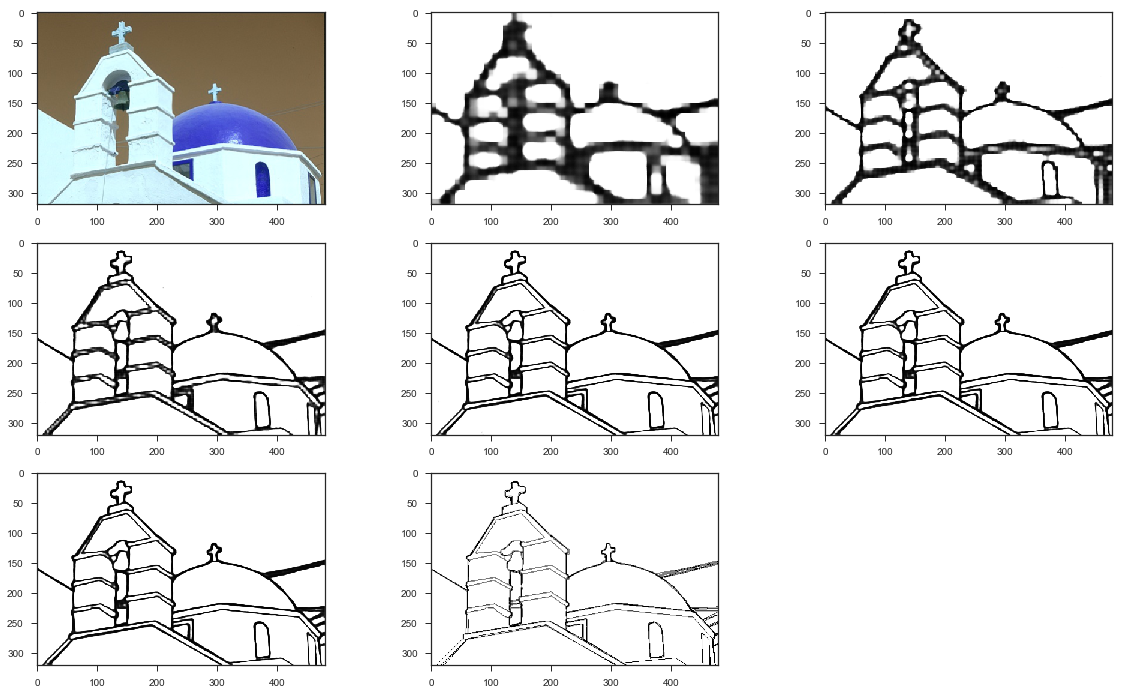

In [9]:
y_pred = model_unet_res_fuse.predict(X_train[18].reshape((-1,320,480,3)))
plt.figure(figsize=(20, 12))
for i in range(0, 8):
    plt.subplot(3, 3, i+1)
    if i == 0:
        plt.imshow(X_train[18], cmap='binary')
    elif i == 7:
        plt.imshow(y_train[18].reshape((320, 480)), cmap='binary')
    else:
        plt.imshow(y_pred[i-1].reshape((320, 480)), cmap='binary')
plt.show()

In [11]:
model_unet_load = u_res_side_fuse(input_shape=(320, 480, 3))
model_unet_load.load_weights('/media/tulan/Linux/Pycharm/Image_Edge/weight/UNET_res_fuse_weight.h5')

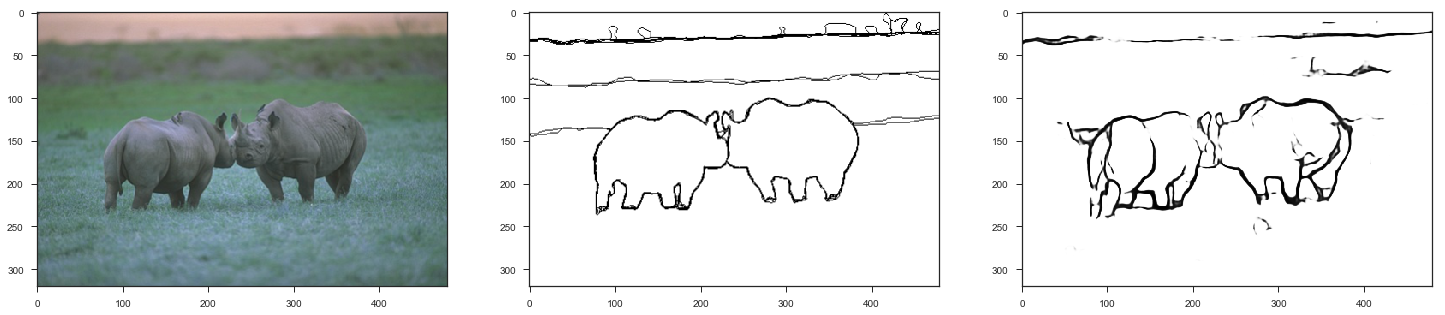

In [19]:
y_pred = model_unet_load.predict(X_test[22].reshape((-1,320,480,3)))[-1]
y_pred = y_pred.reshape((320, 480))
# np.savetxt(RESULT_PATH + '/sample_pred.csv', y_pred, fmt='%3f')
# y_pred[y_pred >= 0.5] = 1
# y_pred[y_pred < 0.5] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_test[22], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_test[22].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')
plt.show()